2018 Nov 1<br>
This notebook contains the final, published analysis of the Kepler lightcurves for the Kepler-76 system. 

In [5]:
%matplotlib inline
%load_ext autoreload
# %load_ext ipycache
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

# from astropy import units as u
# from astropy.constants import c

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from pymc import geweke
from pymc.Matplot import geweke_plot
from corner import quantile

from PyAstronomy.modelSuite import forTrans as ft
from PyAstronomy.pyasl import isInTransit

from lightkurve import KeplerLightCurveFile, KeplerTargetPixelFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import *
from transit_utils import bindata

from scipy.signal import lombscargle
from scipy.stats import ks_2samp
from scipy.optimize import fmin

from lmfit import minimize, Parameters, Minimizer
from emcee.autocorr import integrated_time, function
import corner

from variable_eclipses_utils import *
from BEER_curve import BEER_curve

import dill
import pickle

K76 = Kepler76_params()

exp_time = 30./60./24.

# Official Boise State colors - https://brandstandards.boisestate.edu/colors/
BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'

aspect_ratio = 16./9

# 2018 Dec 21 
# dill.load_session("Analysis_of_Kepler76b_2018Dec7.db")

# cached = ipycache.load_vars('Analysis_of_Kepler76b_2018Dec14.pkl', ['new_BEER_out'])
# new_BEER_out = cached['new_BEER_out']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# dill.dump_session("Analysis_of_Kepler76b_2019Mar25.db")
dill.load_session("Analysis_of_Kepler76b_2019Mar25.db")

Make plot of eclipse depth vs. num_periods to condition data

In [7]:
# Calculate BEER_curve
def calc_BEER_curve(time, params, exp_time=K76.exp_time, supersample_factor=K76.supersample_factor):
    BC = BEER_curve(time, params, exp_time=exp_time, supersample_factor=supersample_factor)
    return BC.all_signals()

def residuals(params, time, data, eps_data=1., model_to_use=calc_BEER_curve, 
              exp_time=K76.exp_time, supersample_factor=K76.supersample_factor):
    model = model_to_use(time, params, exp_time=exp_time, supersample_factor=supersample_factor)
    
    return (data - model)/eps_data

In [8]:
params = Parameters()

# Use best-fit values from Faigler et al. (2013)
params.add('per', value=K76.per.to('day').value, vary=False)
params.add('a', value=K76.a, vary=False)
params.add('b', value=K76.b, vary=False)
params.add('T0', value=K76.T0, vary=False)
params.add('p', value=K76.Rp_over_Rs, vary=False)
params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
params.add('Abeam', value=13e-6, min=-1000e-6, max=1000e-6)
params.add('Aplanet', value=60e-6, min=-1000e-6, max=1000e-6)
params.add('phase_shift', value=0., min=-1000e-6, max=1000e-6)
params.add('eclipse_depth', value=89e-6, min=-1000e-6, max=1000e-6)

trial_num_periods = range(1, 16)
eclipse_depths = np.array([])
eclipse_depths_errs = np.array([])
Aplanets = np.array([])
Aplanets_errs = np.array([])
redchis = np.array([])

for i in range(len(trial_num_periods)):

# Retrieve while masking out transit
    unfiltered_time, unfiltered_flux, filtered_time, filtered_flux, _ =\
        retreive_data(num_periods=trial_num_periods[i], KIC=K76.KIC, params=dict(params.valuesdict()), 
                      drop_outliers=True)
    folded_time = filtered_time % K76.saved_ep.per

    # Grab the out-of-transit portion
    ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)

    time = folded_time[ind]
    data = filtered_flux[ind]
    err = np.ones_like(data) # Don't worry about scatter.
    
    out = minimize(residuals, params, args=(time, data), kws={'eps_data': err, 'model_to_use': calc_BEER_curve})

    eclipse_depths = np.append(eclipse_depths, out.params['eclipse_depth'].value)
    eclipse_depths_errs = np.append(eclipse_depths_errs, out.params['eclipse_depth'].stderr)
    
    Aplanets = np.append(Aplanets, out.params['Aplanet'].value)
    Aplanets_errs = np.append(Aplanets_errs, out.params['Aplanet'].stderr)
    
    redchis = np.append(redchis, out.redchi)

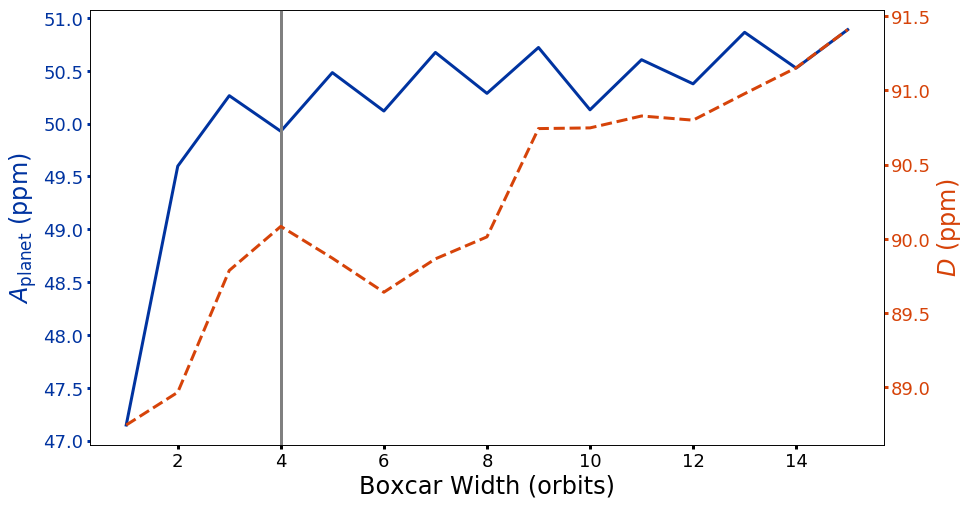

In [11]:
num_periods = 4

fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(111)
ax1.plot(trial_num_periods, Aplanets*1e6, lw=3, color=BoiseState_blue)
ax1.set_xlabel("Boxcar Width (orbits)", fontsize=24)
ax1.set_ylabel("$A_{\\rm planet}$ (ppm)", color=BoiseState_blue, fontsize=24)
ax1.tick_params('y', colors=BoiseState_blue, labelsize=18)
ax1.tick_params('x', labelsize=18)

ax2 = ax1.twinx()
ax2.plot(trial_num_periods, eclipse_depths*1e6, lw=3, color=BoiseState_orange, ls='--')
ax2.set_ylabel("$D$ (ppm)", color=BoiseState_orange, fontsize=24)
ax2.tick_params('y', colors=BoiseState_orange, labelsize=18)

ax2.axvline(4, lw=3, zorder=-1, color='grey')

2018 Nov 5 - Plot of raw and conditioned data

In [12]:
num_periods = 4

unfiltered_time, unfiltered_flux, filtered_time, filtered_flux, returned_filter =\
    retreive_data(num_periods=num_periods, KIC=K76.KIC, params=dict(params.valuesdict()), drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

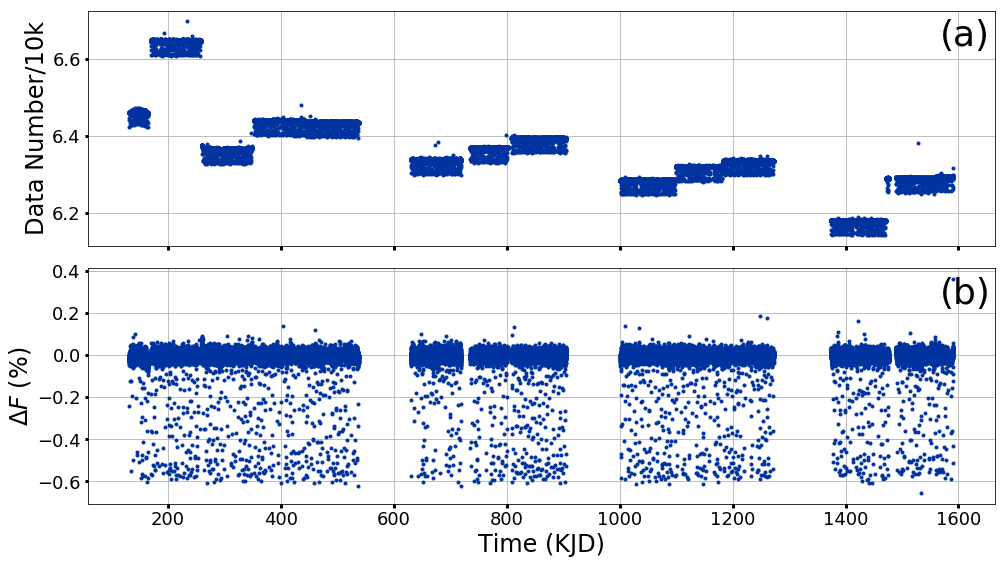

In [13]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot(unfiltered_time, unfiltered_flux/10000, marker='.', color=BoiseState_blue, ls='')
ax1.tick_params(labelbottom=False, labelsize=18)
ax1.annotate("(a)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax1.set_ylabel("Data Number/10k", fontsize=24)

ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.plot(filtered_time, filtered_flux*100, marker='.', color=BoiseState_blue, ls='')
ax2.annotate("(b)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax2.set_xlabel("Time (KJD)", fontsize=24)
ax2.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)

plt.tight_layout()

# fig.savefig("../raw-conditioned-data_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

### Check whether supersampling is necessary for fitting BEER signals

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Acos           4.975e-05   -0.001    0.001 1.35e-06     True     None     None
Aellip         1.298e-05   -0.001    0.001 1.385e-06     True     None     None
Asin           1.166e-05   -0.001    0.001 1.125e-06     True     None     None
T0               0.6851     -inf      inf        0    False     None     None
a                 4.525     -inf      inf        0    False     None     None
b                 0.944     -inf      inf        0    False     None     None
baseline       2.642e-06   -0.001    0.001 8.996e-07     True     None     None
eclipse_depth   8.9e-05     -inf      inf        0    False     None     None
per               1.545     -inf      inf        0    False     None     None
None
3.2322412351306474e-08
(2.1180387564459373, 4.978501857222655e-05)


Text(0.5,0,'Time - $T_{\\rm E}$ (KJD)')

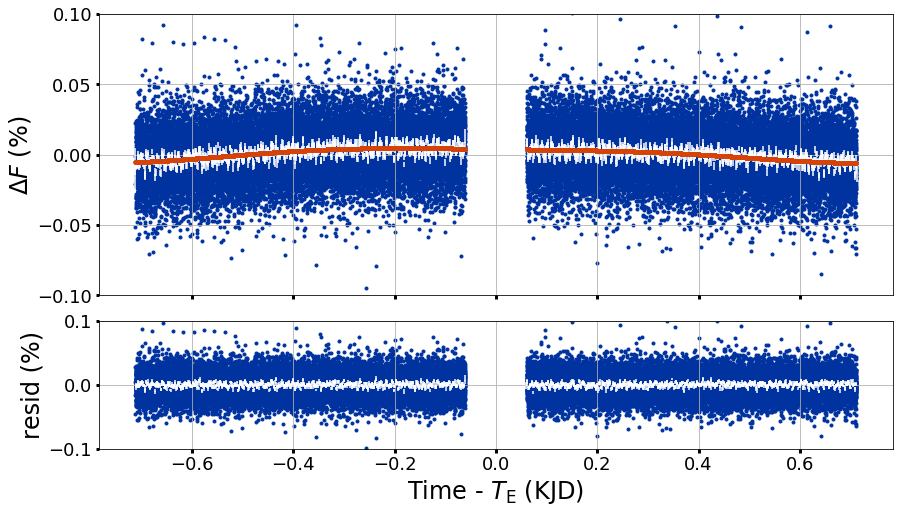

In [14]:
# 2018 Dec 13 - First check whether super-sampling is necessary for the BEER signals 
#
# This cell does NOT include supersampling!
BEER_only_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
BEER_only_params.add('per', value=K76.per.to('day').value, vary=False)
BEER_only_params.add('a', value=K76.a, vary=False)
BEER_only_params.add('b', value=K76.b, vary=False)
BEER_only_params.add('T0', value=K76.T0, vary=False)
BEER_only_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
BEER_only_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Asin', value=13e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Acos', value=60e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('eclipse_depth', value=89e-6, vary=False)

# Grab the out-of-transit portion
ind = ~( transit_indices(folded_time, 2.*K76.dur, K76.T0) |\
         transit_indices(folded_time, 2.*K76.dur, K76.T0 + 0.5*K76.per.to('day').value) )

time = folded_time[ind]
data = filtered_flux[ind]
binned_time, binned_data, binned_err = bindata(time, data, binsize=1./60./24.)
err = np.ones_like(data) # Don't worry about scatter.

BEER_only_out = minimize(residuals, BEER_only_params, args=(time, data), 
                         kws={'eps_data': err, 'model_to_use': calc_BEER_curve, 
                             'exp_time': 0, 'supersample_factor': 1})

BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)

print(BEER_only_out.params.pretty_print())
print(BEER_only_out.redchi)

# Checking whether the Asin and Acos terms give results consistent with Faigler et al. (2013)
Abeam = 13.5e-6 # Faigler et al. (2013)
phase_shift = np.arctan((Abeam - BEER_only_out.params['Asin'])/BEER_only_out.params['Acos'])/2./np.pi
Aplanet = np.sqrt((Abeam - BEER_only_out.params['Asin'])**2 + (BEER_only_out.params['Acos'])**2)
print(phase_shift*360., Aplanet)

fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.grid(True)

ax1.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax1.tick_params('both', labelsize=18, labelbottom=False)

# Center on eclipse
x = (time - (K76.T0 + 0.5*K76.per.to('day').value))
ind = x < -(0.5*K76.per.to('day').value)
x[ind] += K76.per.to('day').value

binned_x = (binned_time - (K76.T0 + 0.5*K76.per.to('day').value))
ind = binned_x < -(0.5*K76.per.to('day').value)
binned_x[ind] += K76.per.to('day').value

y = data*100.
ax1.plot(x, y,  
         marker='.', ls='', color=BoiseState_blue, zorder=-1)
ax1.errorbar(binned_x, binned_data*100., binned_err*100., color='white', ls='')
ax1.plot(x, BEER_only_model*100., 
         marker='.', ls='', color=BoiseState_orange)

ax1.set_ylim([-0.1, 0.1])

ax2 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)
ax2.grid(True)
ax2.plot(x, (data - BEER_only_model)*100., 
         marker='.', ls='', color=BoiseState_blue, zorder=-1)

binned_x, binned_residuals, binned_residuals_err = bindata(x, (data - BEER_only_model), binsize=1./60./24.)
ax2.errorbar(binned_x, binned_residuals*100., binned_residuals_err*100., color='white', ls='')

ax2.set_ylabel("resid (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel("Time - $T_{\\rm E}$ (KJD)", fontsize=24)

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Acos           4.977e-05   -0.001    0.001 1.35e-06     True     None     None
Aellip          1.3e-05   -0.001    0.001 1.387e-06     True     None     None
Asin           1.166e-05   -0.001    0.001 1.126e-06     True     None     None
T0               0.6851     -inf      inf        0    False     None     None
a                 4.525     -inf      inf        0    False     None     None
b                 0.944     -inf      inf        0    False     None     None
baseline       2.642e-06   -0.001    0.001 8.996e-07     True     None     None
eclipse_depth   8.9e-05     -inf      inf        0    False     None     None
per               1.545     -inf      inf        0    False     None     None
None
3.232241235130647e-08


Text(0.5,0,'Time - $T_{\\rm E}$ (KJD)')

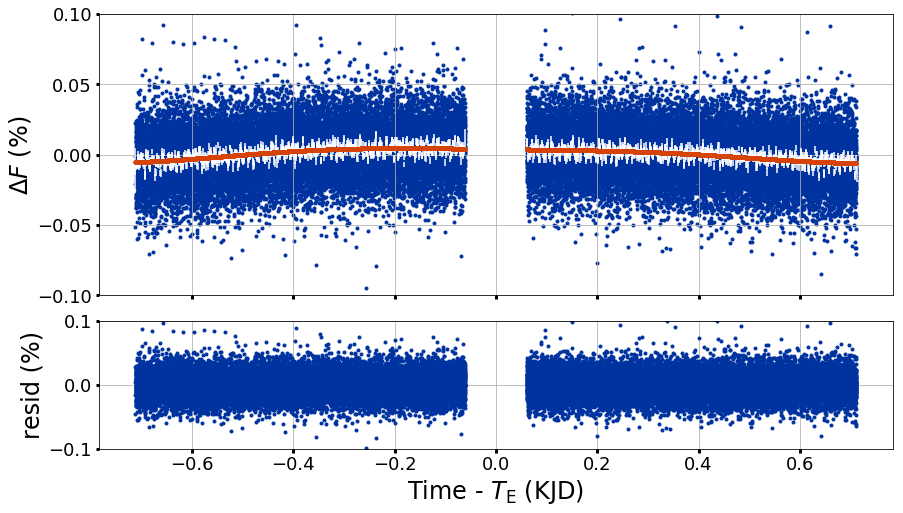

In [15]:
# This cell DOES include supersampling!
BEER_only_out = minimize(residuals, BEER_only_params, args=(time, data), 
                         kws={'eps_data': err, 'model_to_use': calc_BEER_curve})

BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)

print(BEER_only_out.params.pretty_print())
print(BEER_only_out.redchi)


fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.grid(True)

ax1.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax1.tick_params('both', labelsize=18, labelbottom=False)

ax1.plot(x, y,  
         marker='.', ls='', color=BoiseState_blue, zorder=-1)

binned_time, binned_data, binned_err = bindata(time, data, binsize=1./60./24.)
binned_x = (binned_time - (K76.T0 + 0.5*K76.per.to('day').value))
ind = binned_x < -(0.5*K76.per.to('day').value)
binned_x[ind] += K76.per.to('day').value

ax1.errorbar(binned_x, binned_data*100., binned_err*100., color='white', ls='')
ax1.plot(x, BEER_only_model*100., 
         marker='.', ls='', color=BoiseState_orange)

ax1.set_ylim([-0.1, 0.1])

ax2 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)
ax2.grid(True)
ax2.plot(x, (data - BEER_only_model)*100., 
         marker='.', ls='', color=BoiseState_blue)
ax2.set_ylabel("resid (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel("Time - $T_{\\rm E}$ (KJD)", fontsize=24)

2018 Dec 12 <br>
Using LM to fit the out-of-eclipse and out-of-transit portion, you get the same fit parameters to several decimal places with and without supersampling! So to save a little time, I'm going to apply an MCMC analysis to the same data but without supersampling!

#### What if I hold Abeam fixed at Faigler et al.'s value? What values do I get for Aplanet and delta?

In [16]:
# Using Faigler's reported Abeam, what do you get?
# 2018 Dec 13 - First check whether super-sampling is necessary for the BEER signals 
#
# This cell does NOT include supersampling!
BEER_only_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
BEER_only_params.add('per', value=K76.per.to('day').value, vary=False)
BEER_only_params.add('a', value=K76.a, vary=False)
BEER_only_params.add('b', value=K76.b, vary=False)
BEER_only_params.add('T0', value=K76.T0, vary=False)
BEER_only_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
BEER_only_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Abeam', value=13.5e-6, vary=False)
BEER_only_params.add('Aplanet', value=60e-6, min=-1000e-6, max=1000e-6)
# Start out with Faigler's value
BEER_only_params.add('phase_shift', value=10./360, min=-0.25, max=0.25)
BEER_only_params.add('eclipse_depth', value=89e-6, vary=False)

Faigler_BEER_only_out = minimize(residuals, BEER_only_params, args=(time, data), 
                         kws={'eps_data': err, 'model_to_use': calc_BEER_curve, 
                             'exp_time': 0, 'supersample_factor': 1})

BEER_only_model = calc_BEER_curve(time, Faigler_BEER_only_out.params)
Faiglers_model = calc_BEER_curve(time, BEER_only_params)

print(Faigler_BEER_only_out.params['phase_shift'].value*360., Faigler_BEER_only_out.params['phase_shift'].stderr*360.)
print(Faigler_BEER_only_out.params['Aplanet'])

(2.1180438408269753, 1.295991260110928)
<Parameter 'Aplanet', value=4.9785017315843744e-05 +/- 1.35e-06, bounds=[-0.001:0.001]>


---

#### Fit BEER signals

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Acos           4.978e-05   -0.001    0.001 1.372e-06     True     None     None
Aellip         1.299e-05   -0.001    0.001 1.41e-06     True     None     None
Asin           1.168e-05   -0.001    0.001 1.132e-06     True     None     None
T0               0.6851     -inf      inf     None    False     None     None
a                 4.525     -inf      inf     None    False     None     None
b                 0.944     -inf      inf     None    False     None     None
baseline       2.627e-06   -0.001    0.001 9.058e-07     True     None     None
eclipse_depth   8.9e-05     -inf      inf     None    False     None     None
noise          0.0001798        0    0.001 6.13e-07     True     None     None
per               1.545     -inf      inf     None    False     None     None
None


Text(0.5,0,'Time - $T_{\\rm E}$ (KJD)')

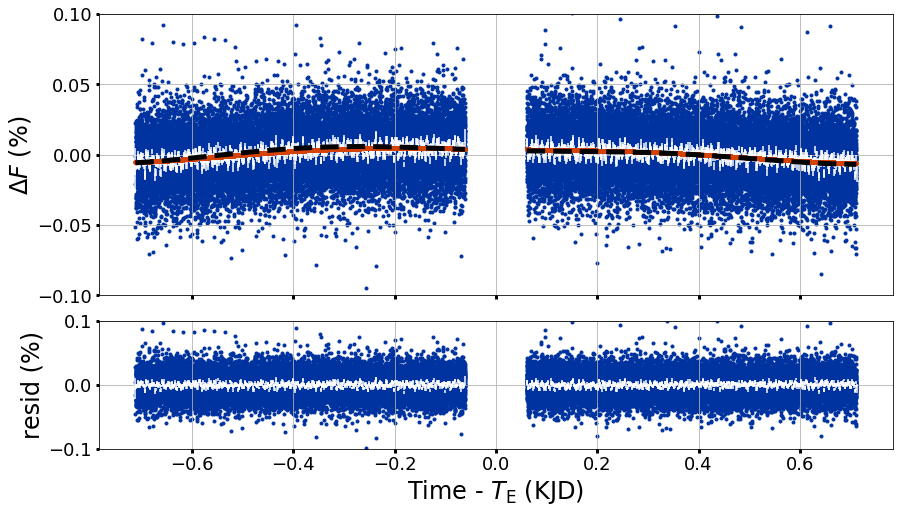

In [19]:
# 2018 Dec 13 - Fitting BEER curve using MCMC WITHOUT supersampling
def fit_BEER_lnprob(p, time, data):
    noise = p['noise']
    resids = calc_BEER_curve(time, p, exp_time=0, supersample_factor=1) - data

    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

BEER_only_params = Parameters()
BEER_only_params.add('per', value=K76.per.to('day').value, vary=False)
BEER_only_params.add('a', value=K76.a, vary=False)
BEER_only_params.add('b', value=K76.b, vary=False)
BEER_only_params.add('T0', value=K76.T0, vary=False)
BEER_only_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
BEER_only_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Asin', value=13e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Acos', value=60e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('eclipse_depth', value=89e-6, vary=False)
BEER_only_params.add('noise', value=mad(filtered_flux), min=0., max=1000e-6)

nwalkers = 100
nsteps = 5000

pos = np.array([(BEER_only_params[cur_key].value + 1e-5*np.random.randn(nwalkers))
                for cur_key in ['baseline', 'Aellip', 'Asin', 'Acos', 'noise']]).transpose()

# Grab the out-of-transit portion
ind = ~( transit_indices(folded_time, 2.*K76.dur, K76.T0) |\
         transit_indices(folded_time, 2.*K76.dur, K76.T0 + 0.5*K76.per.to('day').value) )
time = folded_time[ind]
data = filtered_flux[ind]

# 2019 Mar 26 - Uncomment the following two lines to run the MCMC analysis.
#   Warning: It will probably take about half an hour.
# mini = Minimizer(fit_BEER_lnprob, BEER_only_params, fcn_args=(time, data))
# %time new_BEER_out = mini.emcee(pos=pos, nwalkers=nwalkers, steps=nsteps, params=BEER_only_params)

BEER_only_model = calc_BEER_curve(time, new_BEER_out.params, supersample_factor=1, exp_time=0)

print(new_BEER_out.params.pretty_print())

fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.grid(True)

ax1.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax1.tick_params('both', labelsize=18, labelbottom=False)

ax1.plot(x, y,  
         marker='.', ls='', color=BoiseState_blue, zorder=-1)

binned_time, binned_data, binned_err = bindata(time, data, binsize=1./60./24.)
binned_x = (binned_time - (K76.T0 + 0.5*K76.per.to('day').value))
ind = binned_x < -(0.5*K76.per.to('day').value)
binned_x[ind] += K76.per.to('day').value

ax1.errorbar(binned_x, binned_data*100., binned_err*100., color='white', ls='')
ax1.plot(x, BEER_only_model*100., 
         marker='.', ls='', color=BoiseState_orange)

# Include Faigler's fit
Faiglers_parameters = K76.saved_params.copy()
Faiglers_parameters['baseline'] = new_BEER_out.params['baseline'].value
Faiglers_parameters['eclipse_depth'] = new_BEER_out.params['eclipse_depth'].value
Faiglers_model = calc_BEER_curve(time, Faiglers_parameters)
srt = np.argsort(x)
# Sort so you can use a dashed line
ax1.plot(x[srt][x[srt] < 0], Faiglers_model[srt][x[srt] < 0]*100., ls='--', lw=5, color='black')
ax1.plot(x[srt][x[srt] > 0], Faiglers_model[srt][x[srt] > 0]*100., ls='--', lw=5, color='black')

ax1.set_ylim([-0.1, 0.1])

ax2 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)
ax2.grid(True)
ax2.plot(x, (data - BEER_only_model)*100., 
         marker='.', ls='', color=BoiseState_blue, zorder=-1)

_, binned_residuals, binned_residuals_err = bindata(time, (data - BEER_only_model), binsize=1./60./24.)
ax2.errorbar(binned_x, binned_residuals*100., binned_residuals_err*100., color='white', ls='')

ax2.set_ylabel("resid (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel("Time - $T_{\\rm E}$ (KJD)", fontsize=24)

# fig.savefig('../BEER-curve-fit_Analysis_of_Kepler76b.png', dpi=500, bbox_inches='tight')

# with open('Analysis_of_Kepler76b_BEER_MCMC_chain.pickle', 'wb') as f:
#     pickle.dump(new_BEER_out, f)

Check convergence of MCMC chains

Text(0,0.5,'noise (ppm)')

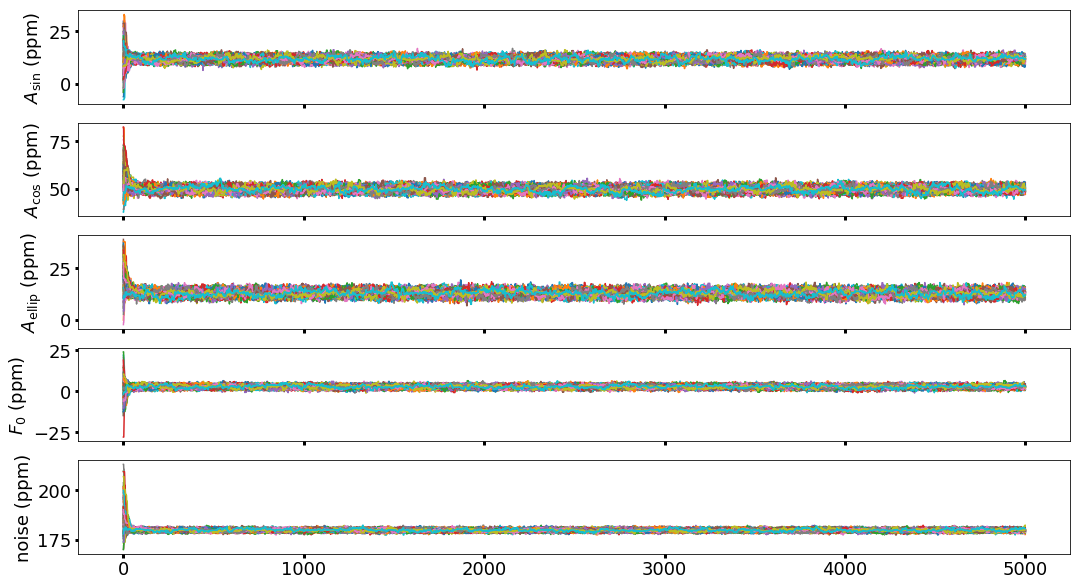

In [35]:
nwalkers = 100
nsteps = 5000

fig = plt.figure(figsize=(aspect_ratio*10, 10))

ax1 = fig.add_subplot(511)
ax1.plot(np.array(new_BEER_out.flatchain['Asin']*1e6).reshape((nwalkers, nsteps)).transpose())
ax1.tick_params(labelbottom=False, labelsize=18)
ax1.set_ylabel('$A_{\\rm sin}$ (ppm)', fontsize=18)

ax2 = fig.add_subplot(512)
ax2.plot(np.array(new_BEER_out.flatchain['Acos']*1e6).reshape((nwalkers, nsteps)).transpose())
ax2.tick_params(labelbottom=False, labelsize=18)
ax2.set_ylabel('$A_{\\rm cos}$ (ppm)', fontsize=18)

ax3 = fig.add_subplot(513, sharex=ax1)
ax3.plot(np.array(new_BEER_out.flatchain['Aellip']*1e6).reshape((nwalkers, nsteps)).transpose())
ax3.tick_params(labelbottom=False, labelsize=18)
ax3.set_ylabel('$A_{\\rm ellip}$ (ppm)', fontsize=18)

ax4 = fig.add_subplot(514)
ax4.plot(np.array(new_BEER_out.flatchain['baseline']*1e6).reshape((nwalkers, nsteps)).transpose())
ax4.tick_params(labelbottom=False, labelsize=18)
ax4.set_ylabel('$F_0$ (ppm)', fontsize=18)

ax5 = fig.add_subplot(515)
ax5.plot(np.array(new_BEER_out.flatchain['noise']*1e6).reshape((nwalkers, nsteps)).transpose())
ax5.tick_params(labelsize=18)
ax5.set_ylabel('noise (ppm)', fontsize=18)

In [36]:
burn = 0
for cur_key in ['baseline', 'Aellip', 'Asin', 'Acos', 'noise']:
    
    mean_chain = np.mean(np.array(new_BEER_out.flatchain[cur_key]).reshape((nwalkers, nsteps)).transpose(), 
                         axis=1)
    max_int_time = integrated_time(mean_chain, c=5)
    print(cur_key, max_int_time)

    burn = int(np.max([burn, 10.*max_int_time]))

# Just to be safe
if(burn < 0.5*len(mean_chain)):
    burn = int(0.5*len(mean_chain))
    
print(burn)

('baseline', 49.38000442127219)
('Aellip', 48.4601638885713)
('Asin', 37.72654877647764)
('Acos', 50.03512414846159)
('noise', 39.151815495527956)
2500


/Users/bjackson/anaconda2/lib/python2.7/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


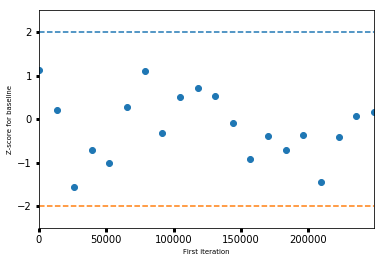

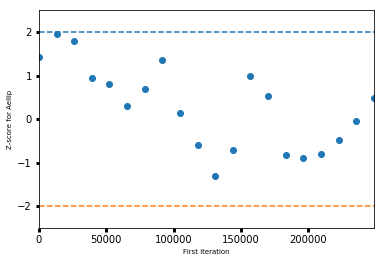

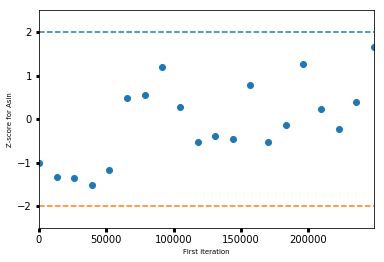

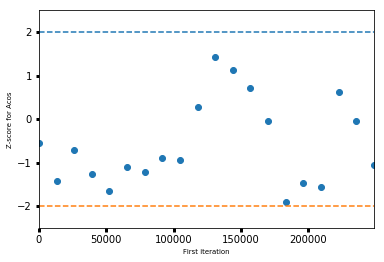

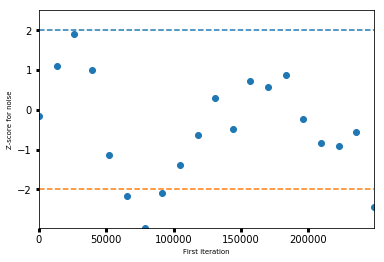

In [37]:
for cur_key in ['baseline', 'Aellip', 'Asin', 'Acos', 'noise']:
    mean_score = geweke(np.array(new_BEER_out.flatchain[cur_key])[burn:])
    geweke_plot(mean_score, name=cur_key)

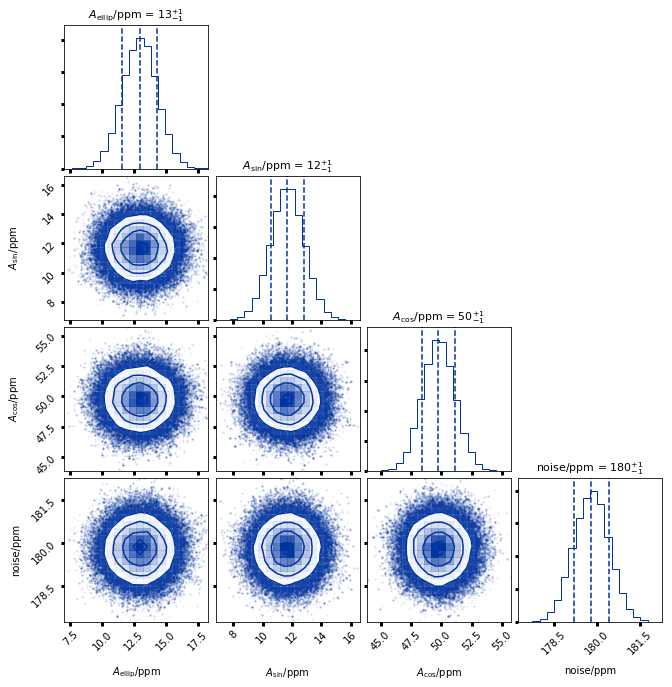

In [39]:
# Make corner plot
Aellip_chain = np.array(new_BEER_out.flatchain['Aellip']).reshape((nwalkers, nsteps)).transpose()
Asin_chain = np.array(new_BEER_out.flatchain['Asin']).reshape((nwalkers, nsteps)).transpose()
Acos_chain = np.array(new_BEER_out.flatchain['Acos']).reshape((nwalkers, nsteps)).transpose()
noise_chain = np.array(new_BEER_out.flatchain['noise']).reshape((nwalkers, nsteps)).transpose()

dists = np.array([Aellip_chain[burn:].flatten()*1e6, Asin_chain[burn:].flatten()*1e6, Acos_chain[burn:].flatten()*1e6, 
                 noise_chain[burn:].flatten()*1e6]).transpose()

Asin = np.quantile(Asin_chain[burn:], 0.5)
Asin_err = np.sqrt((np.quantile(Asin_chain[burn:], 0.84) - Asin)**2 +
                   (np.quantile(Asin_chain[burn:], 0.16) - Asin)**2
                  )

Acos = np.quantile(Acos_chain[burn:], 0.5)
Acos_err = np.sqrt((np.quantile(Acos_chain[burn:], 0.84) - Acos)**2 +
                   (np.quantile(Acos_chain[burn:], 0.16) - Acos)**2
                  )

figure = corner.corner(dists, labels=["$A_{\\rm ellip}/$ppm", "$A_{\\rm sin}/$ppm", 
                                     "$A_{\\rm cos}/$ppm", "noise/ppm"],
                       quantiles=[0.16, 0.5, 0.84], title_fmt=".0f",
                       show_titles=True, title_kwargs={"fontsize": 11}, color=BoiseState_blue)

figure.savefig('../BEER-curve-fit-params_Analysis-of-Kepler76b.png', dpi=500, bbox_inches='tight')

In [42]:
def calc_Aplanet(Abeam, Abeam_err, Asin, Asin_err, Acos, Acos_err):
    cur_Aplanet = np.sqrt((Abeam - Asin)**2 + Acos**2)
    cur_Aplanet_err = np.sqrt((Abeam - Asin)**2*(Abeam_err**2 + Asin_err**2) + Acos**2*Acos_err**2)/cur_Aplanet

    return cur_Aplanet, cur_Aplanet_err

def calc_phase_shift(Abeam, Abeam_err, Asin, Asin_err, Acos, Acos_err):
    cur_tan_phase_shift = (Abeam - Asin)/Acos    
    cur_phase_shift = np.arctan(cur_tan_phase_shift)
    
    cur_phase_shift_err = 1./(1. + cur_tan_phase_shift**2)*\
        np.sqrt((Abeam_err/Acos)**2 + (Asin_err/Acos)**2 + (cur_tan_phase_shift/Acos)**2*Acos_err**2)

    return cur_phase_shift, cur_phase_shift_err

def calc_tan_phase_shift(Abeam, Abeam_err, Asin, Asin_err, Acos, Acos_err):
    cur_tan_phase_shift = (Abeam - Asin)/Acos    
    cur_tan_phase_shift_err = np.sqrt(Abeam_err**2 + Asin_err**2 + (cur_tan_phase_shift/Acos)**2*Acos_err**2)

    return cur_tan_phase_shift, cur_tan_phase_shift_err

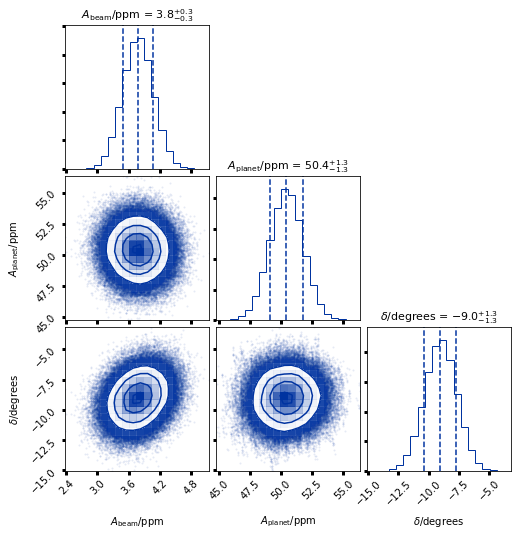

In [43]:
num_points = 250000

# Using the Abeam value suggested by Faigler et al's RV measurements, calculate Aplanet, Abeam, and phase_shift
#   KRV = 0.308 ± 0.020 km/s 
Kz = 0.308/c.to('km/s').value
Kz_err = 0.02/c.to('km/s').value

#   alpha_beam = 0.92 ± 0.04
alpha_beam = 0.92
alpha_beam_err = 0.04

# From Jackson et al. (2012) -- Abeam = alpha_beam 4 (KRV/c)
Abeam = alpha_beam*4.*Kz
Abeam_err = Abeam*np.sqrt((alpha_beam_err/alpha_beam)**2 + (Kz_err/Kz)**2)
Abeam_dist = Abeam + Abeam_err*np.random.randn(num_points)

# Checking whether the Asin and Acos terms give results consistent with Faigler et al. (2013)
tan_phase_shift_dist = (Abeam_dist - Asin_chain[burn:].flatten())/Acos_chain[burn:].flatten()
phase_shift_dist = np.arctan((Abeam_dist - Asin_chain[burn:].flatten())/Acos_chain[burn:].flatten())/2./np.pi*360.
Aplanet_dist = np.sqrt((Abeam_dist - Asin_chain[burn:].flatten())**2 + (Acos_chain[burn:].flatten())**2)

Aplanet = np.quantile(Aplanet_dist, 0.5)
Aplanet_err = np.std(Aplanet_dist)

phase_shift = np.quantile(phase_shift_dist, 0.5)
phase_shift_err = np.std(phase_shift_dist)

tan_phase_shift = np.quantile(tan_phase_shift_dist, 0.5)
tan_phase_shift_err = np.std(tan_phase_shift_dist)

dists = np.array([Abeam_dist*1e6, Aplanet_dist*1e6, phase_shift_dist]).transpose()
figure = corner.corner(dists, labels=["$A_{\\rm beam}/$ppm", "$A_{\\rm planet}/$ppm", "$\delta/$degrees"],
                       quantiles=[0.16, 0.5, 0.84], title_fmt=".1f",
                       show_titles=True, title_kwargs={"fontsize": 11}, color=BoiseState_blue)

# figure.savefig('../Aplanet-delta-fit-params_Analysis-of-Kepler76b.png', dpi=500, bbox_inches='tight')

---
Initial fit to just the transit portion using the best-fit orbital period from Faigler et al. (2013) and the Levenberg-Marquardt algorithm

In [18]:
dill.load_session("Analysis_of_Kepler76b_2018Dec7.db")

In [108]:
# Fit folded transit
initial_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
initial_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
initial_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])
time = folded_time[transit_ind]

# 2018 Nov 16 - BEER only model
BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)
data = filtered_flux[transit_ind] - BEER_only_model
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.606e-05     True     None     None
a            5.116        2       10  0.05499     True     None     None
b           0.9072       -1        1 0.002859     True     None     None
baseline  -1.078e-05   -0.001    0.001 5.009e-06     True     None     None
linLimb      0.313     -inf      inf        0    False     None     None
p          0.08463        0      0.2 0.0005153     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb     0.304     -inf      inf        0    False     None     None
None
1.2758892376101258


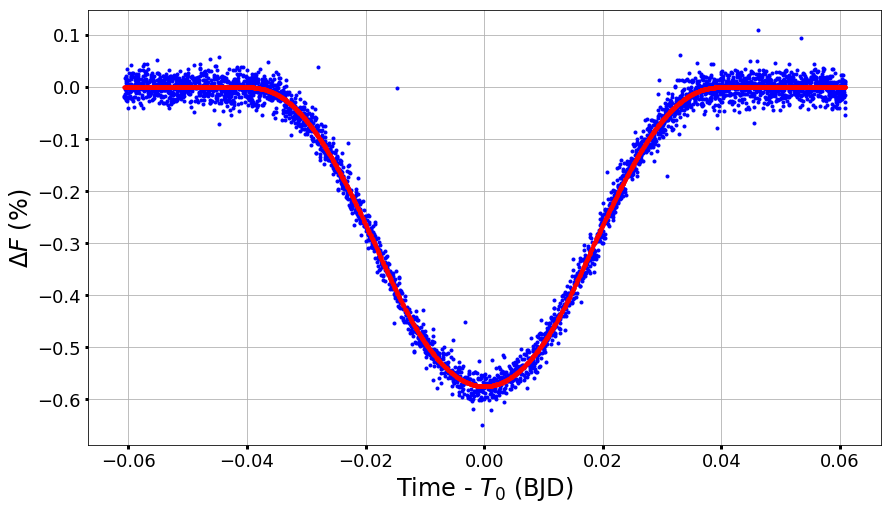

In [109]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(time - out.params['T0'], data*100, 'b.')
ax.plot(time - out.params['T0'], fit_transit(time, out.params)*100, 'r.')

ax.set_xlabel("Time - $T_{\\rm 0}$ (BJD)", fontsize=24)
ax.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax.tick_params('both', labelsize=18)

In [9]:
# Checking how the fit parameters vary if I use limb-darkening coefficients from Espinoza & Jordan (2015)
# http://adsabs.harvard.edu/abs/2015MNRAS.450.1879E

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# From Kepler76_output_file.dat - 
# Kepler-76  A100  KpHiRes
# Teff=6250.0K  log(g)=4.0  [M/H]=-0.1  vturb=2.0
initial_transit_params['linLimb'].value = 0.32587116
initial_transit_params['quadLimb'].value = 0.30272132

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.606e-05     True     None     None
a            5.114        2       10  0.05474     True     None     None
b           0.9069       -1        1 0.002866     True     None     None
baseline  -4.433e-05   -0.001    0.001 5.013e-06     True     None     None
linLimb     0.3259     -inf      inf        0    False     None     None
p          0.08488        0      0.2 0.0005234     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb    0.3027     -inf      inf        0    False     None     None
None
1.2772928754771382


In [10]:
# Checking how the fit parameters vary if I use limb-darkening coefficients from Espinoza & Jordan (2015)
# http://adsabs.harvard.edu/abs/2015MNRAS.450.1879E

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# From Kepler76_output_file.dat - 
# Kepler-76  P100  KpHiRes
# Teff=6300.0K  log(g)=4.0  [M/H]=0.0  vturb=2.0
initial_transit_params['linLimb'].value = 0.44916238
initial_transit_params['quadLimb'].value = 0.19578540

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.606e-05     True     None     None
a            5.141        2       10  0.05574     True     None     None
b           0.9055       -1        1 0.002953     True     None     None
baseline  -4.417e-05   -0.001    0.001 5.019e-06     True     None     None
linLimb     0.4492     -inf      inf        0    False     None     None
p          0.08573        0      0.2 0.0005419     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb    0.1958     -inf      inf        0    False     None     None
None
1.2772196299273708


At least according to Levenberg-Marquardt, I get the same transit parameters (to within uncertainties) for all three sets of limb-darkening parameters.

---

2018 Nov 6 - Fit the mid-transit times

In [20]:
def fit_line_lnprob(p, x, y):
    noise = p['noise']
    resids = (y - (p['slope']*x + p['intercept']))
    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

def fit_quad_lnprob(p, x, y):
    noise = p['noise']
    resids = (y - (p['a']*x**2 + p['b']*x + p['c']))
    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

# Restore previous best-fit parameters
each_transit_params = out.params.copy()

# Hold some parameters fixed - One or two data points in transit does not allow these parameters to be fit!
each_transit_params['a'].vary = False
each_transit_params['p'].vary = False
each_transit_params['b'].vary = False

# Collect each orbit, one at a time and fit mid-transit time
cur_orb = -1
num_orb = np.array([])
midtransit_times = np.array([])
midtransit_times_err = np.array([])
num_points_in_transit = np.array([])
ind = (filtered_time >= np.min(filtered_time)) &\
        (filtered_time < np.min(filtered_time) + each_transit_params['per'].value)
time = filtered_time[ind]
mn_time = np.min(time)

while(mn_time <= np.max(filtered_time)):
# while(mn_time <= np.min(filtered_time) + 5.*each_transit_params['per'].value):
    
    ind = (filtered_time >= mn_time) & (filtered_time < mn_time + each_transit_params['per'].value)
    mn_time += each_transit_params['per'].value
    cur_orb += 1

    time = filtered_time[ind]
    folded_time = filtered_time[ind] % each_transit_params['per'].value
    data = filtered_flux[ind]
    
    # Mask the transit and estimate uncertainties from standard deviation of remaining points
    folded_time = time % each_transit_params['per']
    dur = transit_duration(each_transit_params)
    non_transit_ind = ~isInTransit(folded_time, each_transit_params['T0'], each_transit_params['per'], 0.5*dur, 
                                   boolOutput=True)
    err = np.ones_like(data)*mad(data[non_transit_ind])
    
    # Check there's at least one point in transit
    if(data[~non_transit_ind].size == 0):
        continue
    
    # Adjust initial guess
    new_T0 = K76.T0 + np.floor(np.min(time)/each_transit_params['per'].value)*each_transit_params['per'].value
    each_transit_params['T0'].set(value=new_T0, min=new_T0*0.95, max=new_T0*1.05)
    
    new_out = minimize(residuals, each_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})

    num_orb = np.append(num_orb, cur_orb)
    midtransit_times = np.append(midtransit_times, new_out.params['T0'].value)
    cur_err = new_out.params['T0'].stderr
    if(cur_err is None):
        cur_err = np.nan 
    midtransit_times_err = np.append(midtransit_times_err, cur_err)

ind = ~np.isnan(midtransit_times_err)
x = num_orb[ind]
y = midtransit_times[ind] - new_out.params['per'].value*num_orb[ind] - np.min(midtransit_times[ind])
yerr = midtransit_times_err[ind] 
    
# Fit straight line to mid-transit times
line_fit_params = Parameters()
line_fit_params.add_many(('slope', new_out.params['per'].value, True, 
                         new_out.params['per'].value*0.95, new_out.params['per'].value*1.05, None, False), 
                         ('intercept', np.min(midtransit_times), True,
                         np.min(midtransit_times)*0.95, np.min(midtransit_times)*1.05, None, False), 
                         ('noise', np.median(yerr), True,
                         0., 10.*np.max(yerr), None, False))

# mini = Minimizer(fit_line_lnprob, line_fit_params, fcn_args=(num_orb, midtransit_times))
# %time line_out = mini.emcee(burn=300, steps=1000, params=line_fit_params)

# LM analysis instead
# line_out = minimize(fit_line, line_fit_params, args=(num_orb[ind], midtransit_times[ind]), 
#            kws={'err': midtransit_times_err[ind]})
# print(line_out.redchi, line_out.aic, line_out.bic)

print("Linear Fit")
print(line_out.params.pretty_print(precision=8))
print(integrated_time(line_out.flatchain['slope']), integrated_time(line_out.flatchain['intercept']))
# From Faigler et al. (2013) - Subtracting off Kepler's T0 offset
Faigler_T0 = 2454966.54811 - 2454833. - 1.54492875 #Last number is Faigler's orbital period
print("Faigler's T0: ", Faigler_T0)
print("\n")

# Fit quadratic to mid-transit times
quad_fit_params = Parameters()
quad_fit_params.add_many(('b', new_out.params['per'].value, True, 
                         new_out.params['per'].value*0.95, new_out.params['per'].value*1.05, None, False), 
                         ('c', np.min(midtransit_times), True,
                         np.min(midtransit_times)*0.95, np.min(midtransit_times)*1.05, None, False),
                         ('a', -0.1, True,
                         -1., 1., None, False), 
                         ('noise', np.median(yerr), True,
                         0., 10.*np.max(yerr), None, False))

# LM analysis instead
# quad_out = minimize(fit_quad, quad_fit_params, args=(num_orb[ind], midtransit_times[ind]), 
#            kws={'err': midtransit_times_err[ind]})
# print(quad_out.redchi, quad_out.aic, quad_out.bic)

# mini = Minimizer(fit_quad_lnprob, quad_fit_params, fcn_args=(num_orb, midtransit_times))
# %time quad_out = mini.emcee(burn=1500, steps=5000, params=quad_fit_params)

print("Quad Fit")
print(quad_out.params.pretty_print(precision=8))
print(integrated_time(quad_out.flatchain['a']), integrated_time(quad_out.flatchain['b']), 
      integrated_time(quad_out.flatchain['c']))
# # # And finally check for any periodic signals -
# # #  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
# nout = 10000
# min_freq = 1./np.min(midtransit_times[1:] - midtransit_times[0:-1])
# max_freq = 1./(np.max(midtransit_times) - np.min(midtransit_times[0:-1]))
# f = np.linspace(min_freq, max_freq, nout)
# pgram = lombscargle(midtransit_times, midtransit_times - lin_fit, f)

# # Largest peak barely above the other peaks, suggesting no periodicity
# plt.semilogy(f, pgram)

/Users/bjackson/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/bjackson/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Linear Fit
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
intercept  132.00396 125.40366 138.60404 5.0120096e-05     True     None    False
noise      0.0006471336        0 0.012336858 1.8191525e-05     True     None    False
slope      1.5449287 1.4676823 1.6221752 9.3493531e-08     True     None    False
None
(45.58213763593051, 48.34109392863476)
("Faigler's T0: ", 132.00318124985785)


Quad Fit
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      2.0923311e-10       -1        1 3.70078e-10     True     None    False
b      1.5449285 1.4676823 1.6221752 3.5750062e-07     True     None    False
c      132.00399 125.40366 138.60404 7.1281391e-05     True     None    False
noise  0.00064822845        0 0.012336858 1.8247979e-05     True     None    False
None


/Users/bjackson/anaconda2/lib/python2.7/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


(46.11712455659581, 46.69645577208952, 47.17143846144203)


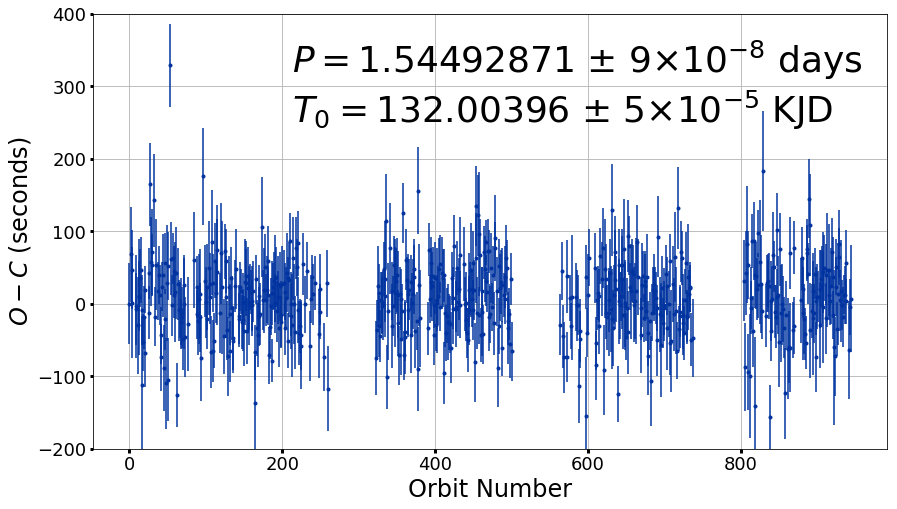

In [26]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)

# 2019 Jan 29 - Convert days to seconds, as per Adams's suggestion
plt.errorbar(x, y*86400., yerr=yerr*86400., marker='.', ls='', color=BoiseState_blue)

ax.set_xlabel("Orbit Number", fontsize=24)
ax.set_ylabel("$O - C$ (seconds)", fontsize=24)
ax.tick_params('both', labelsize=18)

ax.set_ylim([-200, 400])

period_err_exp = np.floor(np.log10(line_out.params['slope'].stderr))
period_err_digit = np.floor(line_out.params['slope'].stderr/10**(period_err_exp))

T0_err_exp = np.floor(np.log10(line_out.params['intercept'].stderr))
T0_err_digit = np.floor(line_out.params['intercept'].stderr/10**(T0_err_exp))

ax.annotate(("$P = $%.8f $\\pm$ %1d$\\times 10^{%d}$ days\n" +\
             "$T_0 = $%.5f $\\pm$ %1d$\\times 10^{%d}$ KJD") % 
            (line_out.params['slope'].value, period_err_digit, period_err_exp, 
             line_out.params['intercept'].value, T0_err_digit, T0_err_exp), 
            xy=(0.9, 0.9), xytext=(0.25, 0.75), xycoords='axes fraction', textcoords='axes fraction',
            fontsize=36, arrowprops=None)

fig.savefig("../TTVs_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

In [75]:
# Check mid-transit time uncertainties using MCMC analysis

# Check transit ephemeris using ONLY the transit signal
def lnprob(p, time, data, model_to_use=fit_transit):
    noise = p['noise']
    resids = residuals(p, time, data, model_to_use=fit_transit)
    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

# Restore previous best-fit parameters
MCMC_each_transit_params = out.params.copy()

# Hold some parameters fixed - One or two data points in transit does not allow these parameters to be fit!
MCMC_each_transit_params['a'].vary = False
MCMC_each_transit_params['p'].vary = False
MCMC_each_transit_params['b'].vary = False

MCMC_each_transit_params.add('noise', value=mad(filtered_flux), vary=True, min=-0.01, max=0.1)

#Collect each orbit, one at a time and fit mid-transit time
cur_orb = -1
orbit_num = 2

ind = (filtered_time >= np.min(filtered_time)) &\
        (filtered_time < np.min(filtered_time) + each_transit_params['per'].value)
time = filtered_time[ind]
mn_time = np.min(time) + orbit_num*each_transit_params['per'].value

ndim, nwalkers = len(MCMC_each_transit_params.keys()), 100

# while(mn_time <= np.max(filtered_time)):
while(mn_time < np.min(filtered_time) + (orbit_num + 1)*each_transit_params['per'].value):
    
    ind = (filtered_time >= mn_time) & (filtered_time < mn_time + each_transit_params['per'].value)
    mn_time += each_transit_params['per'].value
    cur_orb += 1

    time = filtered_time[ind]
    folded_time = filtered_time[ind] % each_transit_params['per'].value
    data = filtered_flux[ind]
    
    # Mask the transit and estimate uncertainties from standard deviation of remaining points
    folded_time = time % each_transit_params['per']
    dur = transit_duration(each_transit_params)
    non_transit_ind = ~isInTransit(folded_time, MCMC_each_transit_params['T0'], MCMC_each_transit_params['per'], 
                                   0.5*dur, boolOutput=True)
    MCMC_each_transit_params['noise'].value = mad(data[non_transit_ind])
    
    # Check there's at least one point in transit
    if(data[~non_transit_ind].size == 0):
        continue
    
    # Adjust initial guess
    new_T0 = K76.T0 +\
        np.floor(np.min(time)/MCMC_each_transit_params['per'].value)*MCMC_each_transit_params['per'].value
    MCMC_each_transit_params['T0'].set(value=new_T0, min=new_T0*0.95, max=new_T0*1.05)

    mini = Minimizer(lnprob, MCMC_each_transit_params, fcn_args=(time, data), fcn_kws={'model_to_use': fit_transit})
    
    # Initialize walkers in a ball around the best-fit position 
    pos = np.array([MCMC_each_transit_params[cur_key].value*\
                    (1. + 1e-4*np.random.randn(nwalkers))
                    for cur_key in ['T0', 'baseline', 'noise']]).transpose()

    %time res = mini.emcee(pos=pos, burn=300, steps=1000, params=MCMC_each_transit_params)
    
    print(res.params.pretty_print())

CPU times: user 31.6 s, sys: 32.7 ms, total: 31.6 s
Wall time: 31.6 s
Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           135.1    128.3    141.8 0.0007928     True     None     None
a            5.114        2       10     None    False     None     None
b           0.9072       -1        1     None    False     None     None
baseline  2.136e-05   -0.001    0.001 2.03e-05     True     None     None
linLimb      0.313     -inf      inf     None    False     None     None
noise     0.0001712    -0.01      0.1 1.457e-05     True     None     None
p          0.08464        0      0.2     None    False     None     None
per          1.545     -inf      inf     None    False     None     None
quadLimb     0.304     -inf      inf     None    False     None     None
None


2018 Nov 8 - Now to explore transit fit posteriors using MCMC

In [39]:
# Re-condition data using new period
new_T0 = line_out.params['intercept'].value % line_out.params['slope'].value

new_transit_params = {'per': line_out.params['slope'].value, 'p': K76.saved_ep.p, 'b': K76.saved_ep.b, 
                     'a': K76.saved_ep.a, 'T0': new_T0}

unfiltered_time, unfiltered_flux, filtered_time, filtered_flux, returned_filter =\
    retreive_data(num_periods=num_periods, KIC=K76.KIC, params=new_transit_params, drop_outliers=True)
folded_time = filtered_time % line_out.params['slope'].value

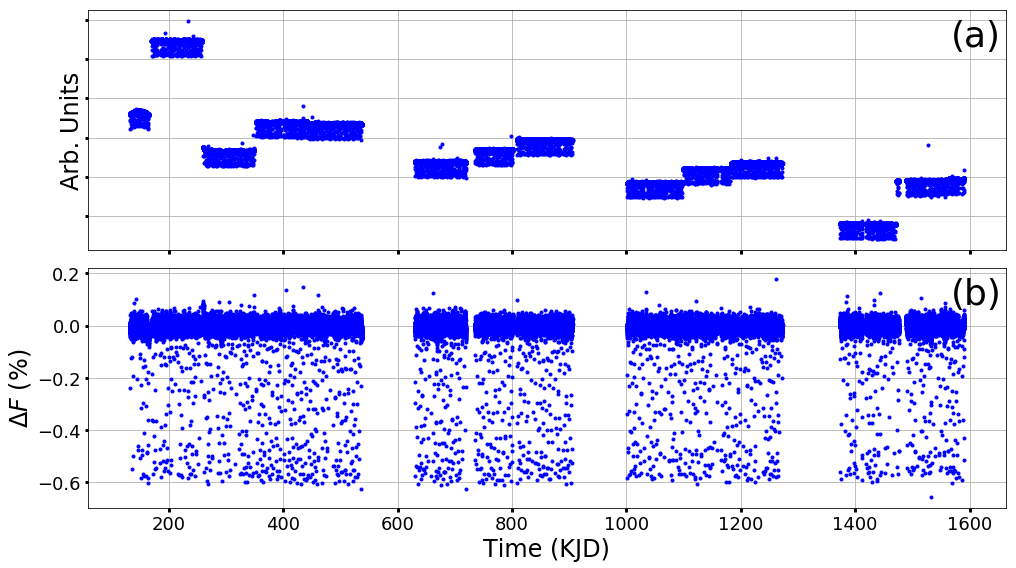

In [2]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot(unfiltered_time, unfiltered_flux, 'b.')
ax1.tick_params(labelbottom=False, labelleft=False)
ax1.annotate("(a)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax1.set_ylabel("Arb. Units", fontsize=24)

ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.plot(filtered_time, filtered_flux*100, 'b.')
ax2.annotate("(b)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax2.set_xlabel("Time (KJD)", fontsize=24)
ax2.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)

plt.tight_layout()

In [101]:
def fit_transit_lnprob(p, time, data):
    noise = p['noise']
    resids = fit_transit(time, p) - data
    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

# Fit folded transit
new_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
new_transit_params.add('per', value=line_out.params['slope'].value, vary=False)
new_transit_params.add('a', value=out.params['a'], min=2., max=10.)
new_transit_params.add('p', value=out.params['p'], min=0., max=0.2)
new_transit_params.add('b', value=out.params['b'], min=-1., max=1.)
new_transit_params.add('T0', value=new_T0, min=new_T0*0.95, max=new_T0*1.05)
new_transit_params.add('baseline', value=10e-6, min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
new_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
new_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, new_T0)
time = folded_time[transit_ind]
data = filtered_flux[transit_ind]

# Initial estimate of noise
noise = mad(filtered_flux[~transit_ind])
new_transit_params.add('noise', value=noise, min=0., max=10.*noise)

# 2018 Nov 13 - Trying to run another set of MCMC analyses using the results from the previous run
nwalkers = 100
nsteps = 4000
pos = np.array([mens[cur_key]*\
                (1. + stds[cur_key]*np.random.randn(nwalkers))
                for cur_key in ['a', 'p', 'b', 'T0', 'baseline', 'noise']]).transpose()
# mini = Minimizer(fit_transit_lnprob, new_transit_params, fcn_args=(time, data))
# %time new_transit_out = mini.emcee(pos=pos, nwalkers=nwalkers, steps=nsteps, params=new_transit_params)
%time new_transit_out = mini.emcee(nwalkers=nwalkers, steps=nsteps, params=new_transit_params, reuse_sampler=True)

print(new_transit_out.params.pretty_print())

CPU times: user 33min 17s, sys: 1min 26s, total: 34min 43s
Wall time: 34min 47s
Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.609e-05     True     None     None
a            5.103        2       10  0.05972     True     None     None
b           0.9078       -1        1 0.003135     True     None     None
baseline  -6.902e-05   -0.001    0.001 5.056e-06     True     None     None
linLimb      0.313     -inf      inf     None    False     None     None
noise     0.0001994        0 0.001766 2.33e-06     True     None     None
p          0.08476        0      0.2 0.0005832     True     None     None
per          1.545     -inf      inf     None    False     None     None
quadLimb     0.304     -inf      inf     None    False     None     None
None


Text(0,0.5,'noise (ppm)')

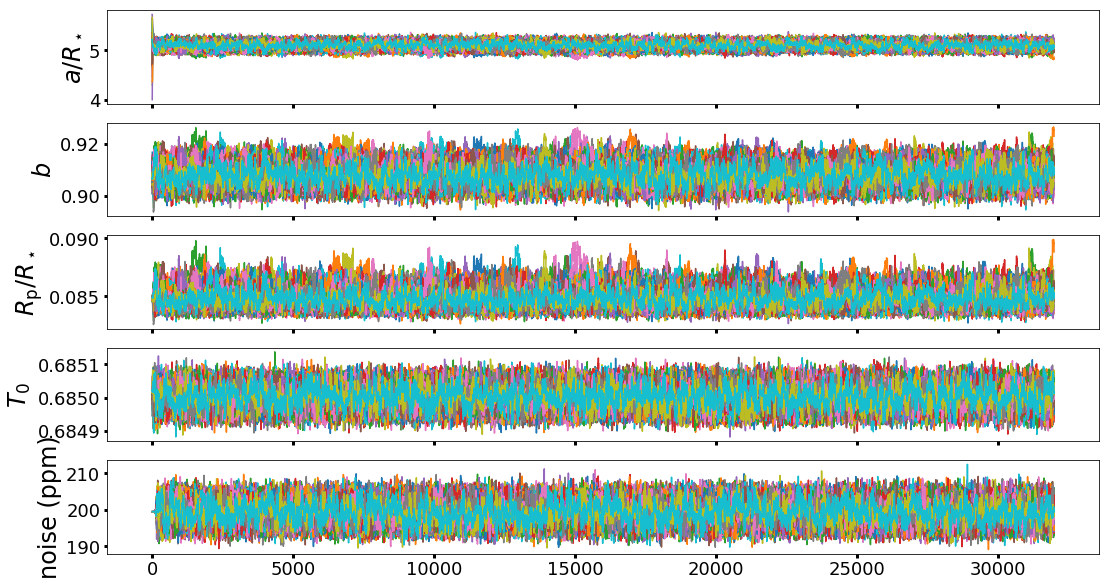

In [103]:
fig = plt.figure(figsize=(aspect_ratio*10, 10))

nsteps = 32000

ax1 = fig.add_subplot(511)
ax1.plot(np.array(new_transit_out.flatchain['a']).reshape((nwalkers, nsteps)).transpose())
ax1.tick_params(labelbottom=False, labelsize=18)
ax1.set_ylabel('$a/R_\star$', fontsize=24)

ax2 = fig.add_subplot(512, sharex=ax1)
ax2.plot(np.array(new_transit_out.flatchain['b']).reshape((nwalkers, nsteps)).transpose())
ax2.tick_params(labelbottom=False, labelsize=18)
ax2.set_ylabel('$b$', fontsize=24)

ax3 = fig.add_subplot(513)
ax3.plot(np.array(new_transit_out.flatchain['p']).reshape((nwalkers, nsteps)).transpose())
ax3.tick_params(labelbottom=False, labelsize=18)
ax3.set_ylabel('$R_{\\rm p}/R_\star$', fontsize=24)

ax4 = fig.add_subplot(514)
ax4.plot(np.array(new_transit_out.flatchain['T0']).reshape((nwalkers, nsteps)).transpose())
ax4.tick_params(labelbottom=False, labelsize=18)
ax4.set_ylabel('$T_0$', fontsize=24)

ax5 = fig.add_subplot(515)
ax5.plot(np.array(new_transit_out.flatchain['noise']*1e6).reshape((nwalkers, nsteps)).transpose())
ax5.tick_params(labelsize=18)
ax5.set_ylabel('noise (ppm)', fontsize=24)

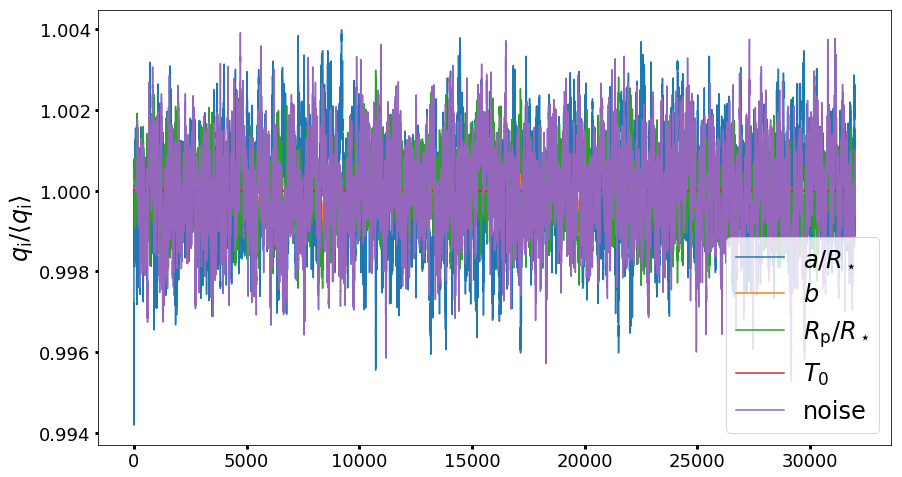

In [31]:
a_chain = np.array(new_transit_out.flatchain['a']).reshape((nwalkers, nsteps)).transpose()
mean_a_chain = np.mean(a_chain, axis=1)
std_a_chain = np.std(a_chain, axis=1)

b_chain = np.array(new_transit_out.flatchain['b']).reshape((nwalkers, nsteps)).transpose()
mean_b_chain = np.mean(b_chain, axis=1)
std_b_chain = np.std(b_chain, axis=1)

p_chain = np.array(new_transit_out.flatchain['p']).reshape((nwalkers, nsteps)).transpose()
mean_p_chain = np.mean(p_chain, axis=1)
std_p_chain = np.std(p_chain, axis=1)

T0_chain = np.array(new_transit_out.flatchain['T0']).reshape((nwalkers, nsteps)).transpose()
mean_T0_chain = np.mean(T0_chain, axis=1)
std_T0_chain = np.std(T0_chain, axis=1)

noise_chain = np.array(new_transit_out.flatchain['noise']).reshape((nwalkers, nsteps)).transpose()
mean_noise_chain = np.mean(noise_chain, axis=1)
std_noise_chain = np.std(noise_chain, axis=1)

baseline_chain = np.array(new_transit_out.flatchain['baseline']).reshape((nwalkers, nsteps)).transpose()
mean_baseline_chain = np.mean(baseline_chain, axis=1)
std_baseline_chain = np.std(baseline_chain, axis=1)

fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)

ax.plot(mean_a_chain/np.mean(mean_a_chain), label='$a/R_\star$')
ax.plot(mean_b_chain/np.mean(mean_b_chain), label='$b$')
ax.plot(mean_p_chain/np.mean(mean_p_chain), label='$R_{\\rm p}/R_\star$')
ax.plot(mean_T0_chain/np.mean(mean_T0_chain), label='$T_0$')
ax.plot(mean_noise_chain/np.mean(mean_noise_chain), label='noise')

ax.set_ylabel('$q_{\\rm i}/\\langle q_{\\rm i} \\rangle$', fontsize=24)
ax.tick_params(labelsize=18)
ax.legend(loc='best', fontsize=24)

/Users/bjackson/anaconda2/lib/python2.7/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


172.4812726131575
227.8357524059596
243.1716648011193
57.17913307488184
55.992893016843304
85.27917713230757


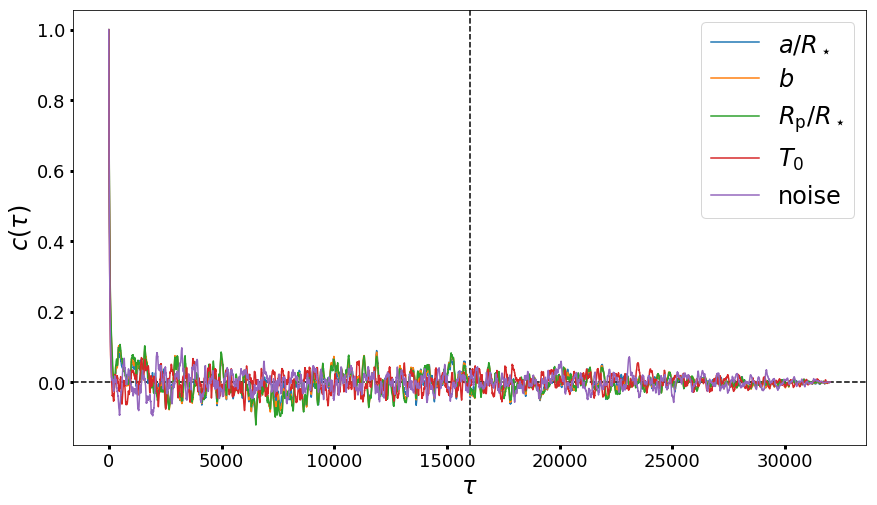

In [8]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)

ax.plot((function(mean_a_chain)), label='$a/R_\star$')
ax.plot((function(mean_b_chain)), label='$b$')
ax.plot((function(mean_p_chain)), label='$R_{\\rm p}/R_\star$')
ax.plot((function(mean_T0_chain)), label='$T_0$')
ax.plot((function(mean_noise_chain)), label='noise')
ax.axhline(0., color='k', ls='--', zorder=-1)

burn = 16000
ax.axvline(burn, color='k', ls='--', zorder=-1)

ax.set_xlabel('$\\tau$', fontsize=24)
ax.set_ylabel('$c\\left( \\tau \\right)$', fontsize=24)
ax.tick_params(labelsize=18)
ax.legend(loc='best', fontsize=24)

# Shorten the required number of auto-correlation times required just a bit (c = 8 instead of c = 10)
print(integrated_time(mean_a_chain, c=8))
print(integrated_time(mean_b_chain, c=8))
print(integrated_time(mean_p_chain, c=8))
print(integrated_time(mean_T0_chain, c=8))
print(integrated_time(mean_noise_chain, c=8))
print(integrated_time(mean_baseline_chain, c=8))

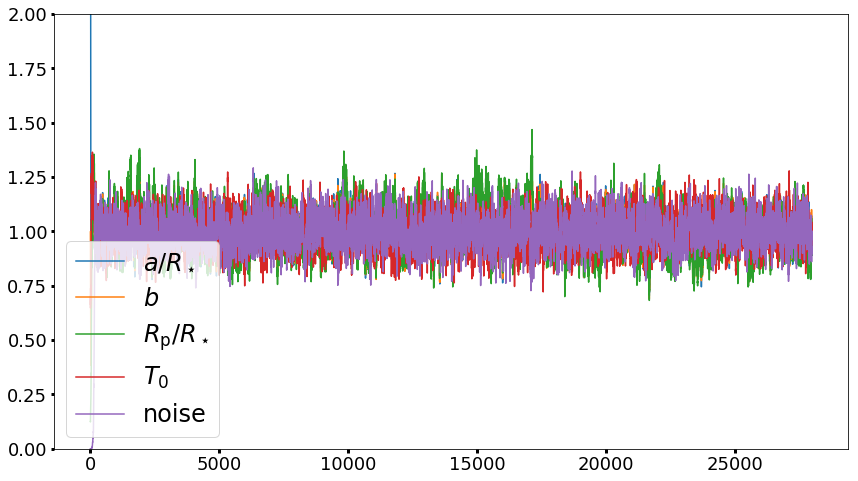

In [98]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)

ax.plot(std_a_chain/np.mean(std_a_chain[burn:]), label='$a/R_\star$')
ax.plot(std_b_chain/np.mean(std_b_chain[burn:]), label='$b$')
ax.plot(std_p_chain/np.mean(std_p_chain[burn:]), label='$R_{\\rm p}/R_\star$')
ax.plot(std_T0_chain/np.mean(std_T0_chain[burn:]), label='$T_0$')
ax.plot(std_noise_chain/np.mean(std_noise_chain[burn:]), label='noise')

ax.set_ylim([0, 2])

ax.tick_params(labelsize=18)
ax.legend(loc='lower left', fontsize=24)

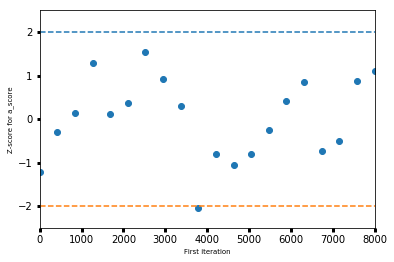

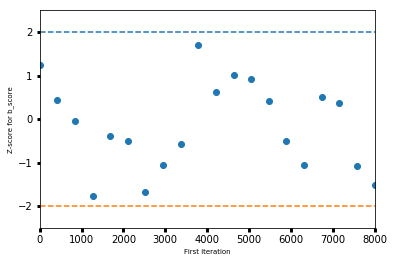

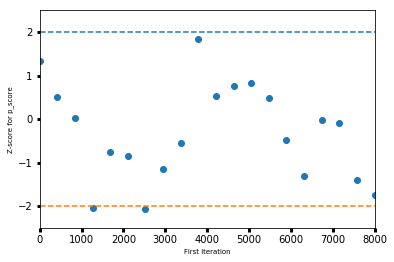

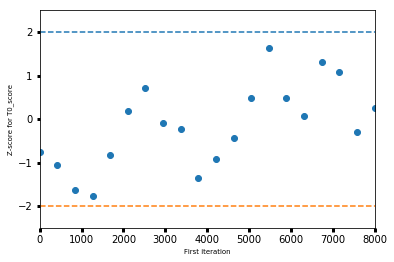

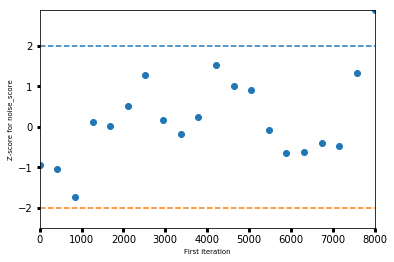

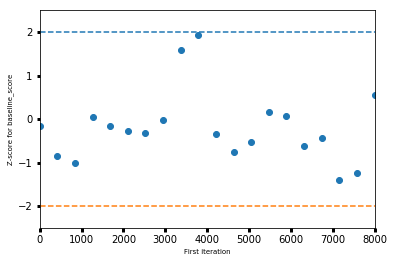

In [9]:
# 2018 Nov 16 - Attempting to use Geweke score from pyMC
mean_a_score = geweke(mean_a_chain[burn:])
geweke_plot(mean_a_score, name="a_score")

mean_b_score = geweke(mean_b_chain[burn:])
geweke_plot(mean_b_score, name="b_score")

mean_p_score = geweke(mean_p_chain[burn:])
geweke_plot(mean_p_score, name="p_score")

mean_T0_score = geweke(mean_T0_chain[burn:])
geweke_plot(mean_T0_score, name="T0_score")

mean_noise_score = geweke(mean_noise_chain[burn:])
geweke_plot(mean_noise_score, name="noise_score")

mean_baseline_score = geweke(mean_baseline_chain[burn:])
geweke_plot(mean_baseline_score, name="baseline_score")

In [9]:
# dill.dump_session("Analysis_of_Kepler76b_2018Nov28.db")
dill.load_session("Analysis_of_Kepler76b_2018Nov28.db")

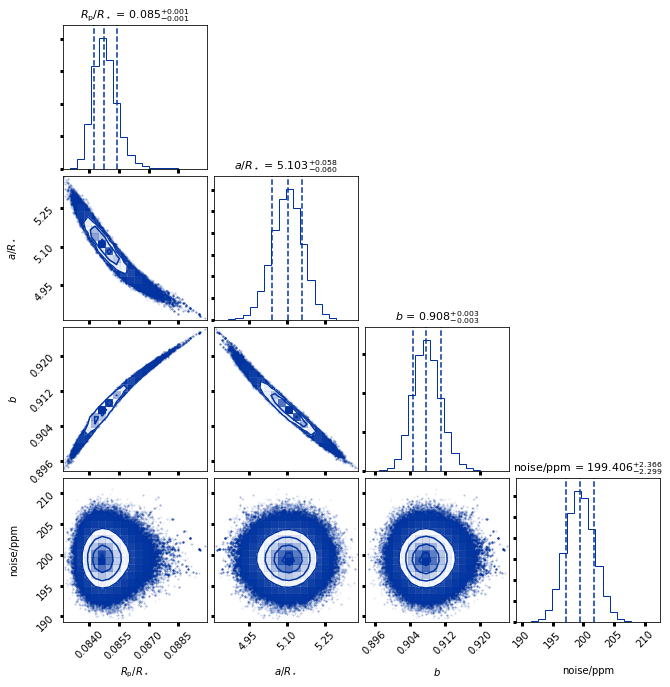

In [10]:
# 2018 Nov 9 - Make corner plot
data = np.array([p_chain[burn:].flatten(), a_chain[burn:].flatten(), b_chain[burn:].flatten(), 
                 noise_chain[burn:].flatten()*1e6]).transpose()

figure = corner.corner(data, labels=["$R_{\\rm p}/R_\star$", "$a/R_\star$", "$b$", "noise/ppm"],
                       quantiles=[0.16, 0.5, 0.84], title_fmt=".3f",
                       show_titles=True, title_kwargs={"fontsize": 11}, color=BoiseState_blue)
# figure.savefig('../folded-transit-corner-plot_Analysis-of-Kepler76b.png', dpi=500, bbox_inches='tight')

0.05735456186865482


Text(0.5,0,'Time - $T_{\\rm 0}$ (KJD)')

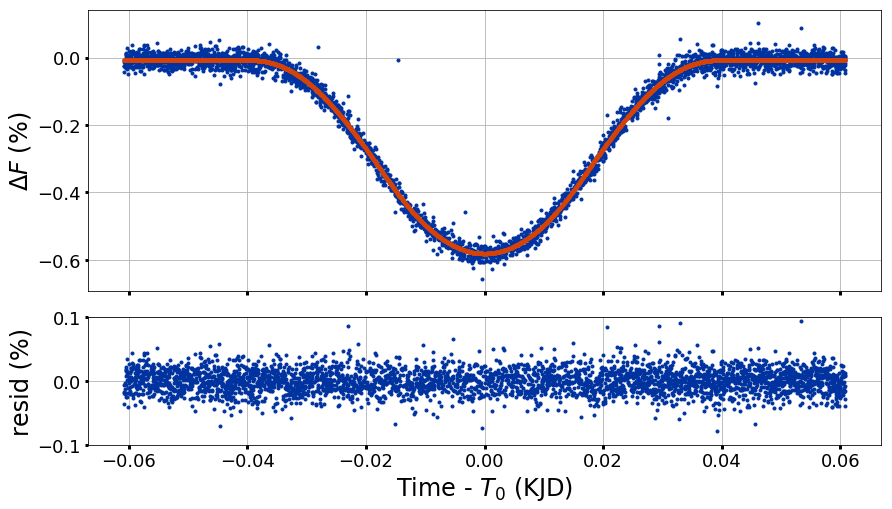

In [30]:
# 2018 Dec 5 - Make plot of best-fit transit curve and residuals
final_best_fit_transit_params = {'per': line_out.params['slope'].value, 
                                 'baseline': np.quantile(baseline_chain[burn:].flatten(), 0.5),
                                 'a': np.quantile(a_chain[burn:].flatten(), 0.5), 
                                 'T0': np.quantile(T0_chain[burn:].flatten(), 0.5),
                                 'p': np.quantile(p_chain[burn:].flatten(), 0.5), 
                                 'b': np.quantile(b_chain[burn:].flatten(), 0.5), 
                                 'linLimb': K76.coeffs[0], 
                                 'quadLimb': K76.coeffs[1]}

noise = np.quantile(noise_chain[burn:].flatten(), 0.5)

new_duration = transit_duration(final_best_fit_transit_params)
print(new_duration)

fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.grid(True)

ax1.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax1.tick_params('both', labelsize=18, labelbottom=False)

final_best_fit_transit_curve = fit_transit(folded_time[transit_ind], final_best_fit_transit_params)
ax1.plot(folded_time[transit_ind] - final_best_fit_transit_params['T0'], filtered_flux[transit_ind]*100., 
         marker='.', ls='', color=BoiseState_blue)
ax1.plot(folded_time[transit_ind] - final_best_fit_transit_params['T0'], final_best_fit_transit_curve*100., 
         marker='.', ls='', color=BoiseState_orange)

ax2 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)
ax2.grid(True)
ax2.plot(folded_time[transit_ind] - final_best_fit_transit_params['T0'], 
         (filtered_flux[transit_ind] - final_best_fit_transit_curve)*100., 
         marker='.', ls='', color=BoiseState_blue)
ax2.set_ylabel("resid (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel("Time - $T_{\\rm 0}$ (KJD)", fontsize=24)

# fig.savefig("../final_best_fit_transit_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

In [6]:
# Save all notebook results so I don't have to re-run everything every time I open the notebook.
dill.dump_session('Analysis_of_Kepler76b_2018Dec5.db')

---

2018 Dec 14<br>
Now to fit the eclipse and BEER signals together, a few orbits at a time

In [3]:
def calc_Aplanet(Abeam, Abeam_err, Asin, Asin_err, Acos, Acos_err):
    cur_Aplanet = np.sqrt((Abeam - Asin)**2 + Acos**2)
    cur_Aplanet_err = np.sqrt((Abeam - Asin)**2*(Abeam_err**2 + Asin_err**2) + Acos**2*Acos_err**2)/cur_Aplanet

    return cur_Aplanet, cur_Aplanet_err

def calc_phase_shift(Abeam, Abeam_err, Asin, Asin_err, Acos, Acos_err):
    cur_tan_phase_shift = (Abeam - Asin)/Acos    
    cur_phase_shift = np.arctan(cur_tan_phase_shift)
    
    cur_phase_shift_err = 1./(1. + cur_tan_phase_shift**2)*\
        np.sqrt((Abeam_err/Acos)**2 + (Asin_err/Acos)**2 + (cur_tan_phase_shift/Acos)**2*Acos_err**2)

    return cur_phase_shift, cur_phase_shift_err

def calc_tan_phase_shift(Abeam, Abeam_err, Asin, Asin_err, Acos, Acos_err):
    cur_tan_phase_shift = (Abeam - Asin)/Acos    
    cur_tan_phase_shift_err = np.sqrt(Abeam_err**2 + Asin_err**2 + (cur_tan_phase_shift/Acos)**2*Acos_err**2)

    return cur_tan_phase_shift, cur_tan_phase_shift_err

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Acos           5.065e-05   -0.001    0.001 1.148e-06     True     None     None
Aellip         1.266e-05   -0.001    0.001 1.156e-06     True     None     None
Asin            1.1e-05     -inf      inf        0    False     None     None
T0                0.685     -inf      inf        0    False     None     None
a                 5.103     -inf      inf        0    False     None     None
b                0.9078     -inf      inf        0    False     None     None
baseline       1.733e-06   -0.001    0.001 7.705e-07     True     None     None
eclipse_depth  8.723e-05   -0.001    0.001 5.315e-06     True     None     None
per               1.545     -inf      inf        0    False     None     None
None
0.8113503020916542
('Aplanet \\pm Aplanet_err: ', (5.1166841600686044e-05, 1.1368642022833476e-06))
('delta \\pm delta_err: ', -8.111062107381295, 0.37436848616354473)


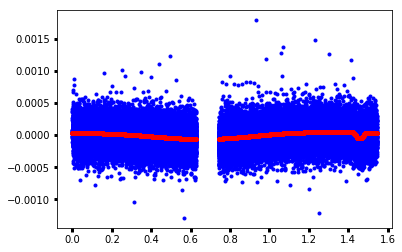

In [39]:
# Start by fitting everything folded together

BEER_and_eclipse_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
BEER_and_eclipse_params.add('per', value=final_best_fit_transit_params['per'], vary=False)
BEER_and_eclipse_params.add('a', value=final_best_fit_transit_params['a'], vary=False)
BEER_and_eclipse_params.add('b', value=final_best_fit_transit_params['b'], vary=False)
BEER_and_eclipse_params.add('T0', value=final_best_fit_transit_params['T0'], vary=False)
BEER_and_eclipse_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
BEER_and_eclipse_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
BEER_and_eclipse_params.add('eclipse_depth', value=98.9e-6, min=-1000e-6, max=1000e-6)

# BEER_and_eclipse_params.add('Abeam', value=3.8e-6, vary=False)
# BEER_and_eclipse_params.add('Aplanet', value=50.5e-6, min=-1000e-6, max=1000e-6)
# BEER_and_eclipse_params.add('phase_shift', value=-8.6/360., min=-0.25, max=0.25)

BEER_and_eclipse_params.add('Asin', value=11.e-6, vary=False)
BEER_and_eclipse_params.add('Acos', value=50.e-6, min=-1000e-6, max=1000e-6)

# Grab the out-of-transit portion
ind = ~ transit_indices(folded_time, 2.*new_duration, final_best_fit_transit_params['T0'])
time = folded_time[ind]
data = filtered_flux[ind]
err = noise*np.ones_like(time)

all_data_BEER_and_eclipse_out = minimize(residuals, BEER_and_eclipse_params, args=(time, data), 
                         kws={'eps_data': err, 'model_to_use': calc_BEER_curve})

# Rescale uncertainties using reduced chi-squared
redchi = all_data_BEER_and_eclipse_out.redchi
for cur_key in all_data_BEER_and_eclipse_out.params.keys():
    all_data_BEER_and_eclipse_out.params[cur_key].stderr *= np.sqrt(redchi)

print(all_data_BEER_and_eclipse_out.params.pretty_print())
print(all_data_BEER_and_eclipse_out.redchi)

print("Aplanet \pm Aplanet_err: ", calc_Aplanet(Abeam, Abeam_err, 
                   all_data_BEER_and_eclipse_out.params['Asin'].value, 
                   all_data_BEER_and_eclipse_out.params['Asin'].stderr, 
                   all_data_BEER_and_eclipse_out.params['Acos'].value, 
                   all_data_BEER_and_eclipse_out.params['Acos'].stderr))

phase_shift, phase_shift_err = calc_phase_shift(Abeam, Abeam_err, 
                       all_data_BEER_and_eclipse_out.params['Asin'].value, 
                       all_data_BEER_and_eclipse_out.params['Asin'].stderr, 
                       all_data_BEER_and_eclipse_out.params['Acos'].value, 
                       all_data_BEER_and_eclipse_out.params['Acos'].stderr)
print("delta \pm delta_err: ", phase_shift*180./np.pi, phase_shift_err*180./np.pi)

BEER_and_eclipse_model = calc_BEER_curve(time, all_data_BEER_and_eclipse_out.params)

# Using the Abeam value suggested by Faigler et al's RV measurements, calculate Aplanet, Abeam, and phase_shift
#   KRV = 0.308 ± 0.020 km/s 
Kz = 0.308/c.to('km/s').value
Kz_err = 0.02/c.to('km/s').value
#   alpha_beam = 0.92 ± 0.04
alpha_beam = 0.92
alpha_beam_err = 0.04
# From Jackson et al. (2012) -- Abeam = alpha_beam 4 (KRV/c)
Abeam = alpha_beam*4.*Kz
Abeam_err = Abeam*np.sqrt((alpha_beam_err/alpha_beam)**2 + (Kz_err/Kz)**2)

plt.plot(time, data, 'b.')
plt.plot(time, BEER_and_eclipse_model, 'r.')

# plt.axhline(all_data_BEER_and_eclipse_out.params['baseline'].value, color='k', ls='--')
# plt.axhline(-all_data_BEER_and_eclipse_out.params['eclipse_depth'].value, color='r', lw=3)

# plt.axhline(all_data_BEER_and_eclipse_out.params['baseline'].value - 
#             all_data_BEER_and_eclipse_out.params['Acos'].value, color='green', ls='--', lw=3)

In [40]:
def fit_all_BEER_and_eclipse_params(ret, folded_time=folded_time, filtered_flux=filtered_flux,
                                    cur_noise=noise, transit_params=final_best_fit_transit_params, 
                                    min_eclipse_points=0, use_MCMC=False):

    mid_times = np.array([])
    BEER_and_eclipse_params = Parameters()

    # Use best-fit values from Faigler et al. (2013)
    BEER_and_eclipse_params.add('per', value=transit_params['per'], vary=False)
    BEER_and_eclipse_params.add('a', value=transit_params['a'], vary=False)
    BEER_and_eclipse_params.add('b', value=transit_params['b'], vary=False)
    BEER_and_eclipse_params.add('T0', value=transit_params['T0'], vary=False)
    BEER_and_eclipse_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
    BEER_and_eclipse_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
    BEER_and_eclipse_params.add('eclipse_depth', value=98.9e-6, min=-1000e-6, max=1000e-6)

    # BEER_and_eclipse_params.add('Abeam', value=3.8e-6, vary=False)
    # BEER_and_eclipse_params.add('Aplanet', value=50.5e-6, min=-1000e-6, max=1000e-6)
    # BEER_and_eclipse_params.add('phase_shift', value=-8.6/360., min=-0.25, max=0.25)

    BEER_and_eclipse_params.add('Asin', value=11.e-6, min=-1000e-6, max=1000e-6)
    BEER_and_eclipse_params.add('Acos', value=50.e-6, min=-1000e-6, max=1000e-6)

    if(use_MCMC):
        BEER_and_eclipse_params.add('noise', value=noise, min=0., max=1000e-6)
    
    BEER_and_eclipse_outs = {}

    for cur_key in ret.keys():
        time = folded_time[ret[cur_key]]
        data = filtered_flux[ret[cur_key]]

        # Grab the out-of-transit portion
        ind = ~transit_indices(time, 2.*new_duration, transit_params['T0'])
        time = time[ind]
        data = data[ind]
        err = cur_noise*np.ones_like(time)

        # And then check that there ARE points in eclipse
        ind = transit_indices(time, new_duration, transit_params['T0'] + 0.5*transit_params['per'])
        if(time[ind].size <= min_eclipse_points):
            continue
        
        if(not use_MCMC):     
            BEER_and_eclipse_out = minimize(residuals, BEER_and_eclipse_params, args=(time, data), 
                                     kws={'eps_data': err, 'model_to_use': calc_BEER_curve})

            # Make sure you don't have anomalous uncertainties
            OK_stderrs = [BEER_and_eclipse_out.params[another_key].stderr >=\
                          all_data_BEER_and_eclipse_out.params[another_key].stderr
                          for another_key in all_data_BEER_and_eclipse_out.params.keys()]

            if((BEER_and_eclipse_out.redchi is not None) and all(OK_stderrs)):
                for another_key in BEER_and_eclipse_out.params.keys():
                    BEER_and_eclipse_out.params[another_key].stderr *= np.sqrt(BEER_and_eclipse_out.redchi)
                    
                mid_times = np.append(mid_times, cur_key)    
                BEER_and_eclipse_outs[cur_key] = BEER_and_eclipse_out
        else:
            nsteps=1000
            nwalkers=100
            
            pos = np.array([(BEER_and_eclipse_params[another_key].value + 1e-5*np.random.randn(nwalkers))
                for another_key in ['baseline', 'Aellip', 'Asin', 'Acos', 'eclipse_depth', 'noise']]).transpose()
            
            mini = Minimizer(fit_BEER_lnprob, BEER_and_eclipse_params, fcn_args=(time, data))
            BEER_and_eclipse_out = mini.emcee(pos=pos, nwalkers=nwalkers, steps=nsteps, params=BEER_and_eclipse_params)
        
            mid_times = np.append(mid_times, cur_key)    
            BEER_and_eclipse_outs[cur_key] = BEER_and_eclipse_out

    return mid_times, BEER_and_eclipse_outs

In [41]:
def collect_phase_curve_params(mid_times, BEER_and_eclipse_outs):
    eclipse_depths = np.array([])
    eclipse_depth_errs = np.array([])

    Asins = np.array([])
    Asin_errs = np.array([])

    Acoss = np.array([])
    Acos_errs = np.array([])

    for cur_key in mid_times:
        eclipse_depths = np.array([BEER_and_eclipse_outs[cur_key].params['eclipse_depth'].value 
                               for cur_key in mid_times])
        eclipse_depth_errs = np.array([BEER_and_eclipse_outs[cur_key].params['eclipse_depth'].stderr 
                               for cur_key in mid_times])

        Asins = np.array([BEER_and_eclipse_outs[cur_key].params['Asin'].value 
                               for cur_key in mid_times])
        Asin_errs = np.array([BEER_and_eclipse_outs[cur_key].params['Asin'].stderr 
                               for cur_key in mid_times])

        Acoss = np.array([BEER_and_eclipse_outs[cur_key].params['Acos'].value 
                               for cur_key in mid_times])
        Acos_errs = np.array([BEER_and_eclipse_outs[cur_key].params['Acos'].stderr 
                               for cur_key in mid_times])      
        
    return eclipse_depths, eclipse_depth_errs, Acoss, Acos_errs, Asins, Asin_errs

In [50]:
def make_phase_curve_plots(mid_times, eclipse_depths, eclipse_depth_errs, Acoss, Acos_errs, Asins, Asin_errs, 
                           ax1, ax2, ax3, ax1a, ax2a, ax3a, marker='.',
                           color=BoiseState_blue, all_data_BEER_and_eclipse_out=all_data_BEER_and_eclipse_out, 
                           aspect_ratio=aspect_ratio):

    x = mid_times
    ax1.errorbar(x, eclipse_depths*1e6, eclipse_depth_errs*1e6,
                ls='', color=color, marker=marker)

    y = (eclipse_depths - all_data_BEER_and_eclipse_out.params['eclipse_depth'].value)/\
         np.sqrt(eclipse_depth_errs**2 + all_data_BEER_and_eclipse_out.params['eclipse_depth'].stderr**2)
    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax1a.plot(hst, bins, color=color)

    y = (Asins - all_data_BEER_and_eclipse_out.params['Asin'].value)/\
             np.sqrt(Asin_errs**2 + all_data_BEER_and_eclipse_out.params['Asin'].stderr**2)
    ax2.errorbar(x, Asins*1e6, Asin_errs*1e6,
            ls='', color=color, marker='.')

    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax2a.plot(hst, bins, color=color)

    y = (Acoss - all_data_BEER_and_eclipse_out.params['Acos'].value)/\
             np.sqrt(Acos_errs**2 + all_data_BEER_and_eclipse_out.params['Acos'].stderr**2)
    ax3.errorbar(x, Acoss*1e6, Acos_errs*1e6,
            ls='', color=color, marker='.')

    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax3a.plot(hst, bins, color=color)

    ax1.axhline(all_data_BEER_and_eclipse_out.params['eclipse_depth'].value*1e6, color=BoiseState_blue)
    ax2.axhline(all_data_BEER_and_eclipse_out.params['Asin'].value*1e6, color=BoiseState_blue)
    ax3.axhline(all_data_BEER_and_eclipse_out.params['Acos'].value*1e6, color=BoiseState_blue)

    ax1a.axhline(-3, color='k', alpha=0.25, ls='--', zorder=-1)
    ax1a.axhline(3, color='k', alpha=0.25, ls='--', zorder=-1)
    ax2a.axhline(-3, color='k', alpha=0.25, ls='--', zorder=-1)
    ax2a.axhline(3, color='k', alpha=0.25, ls='--', zorder=-1)
    ax3a.axhline(-3, color='k', alpha=0.25, ls='--', zorder=-1)
    ax3a.axhline(3, color='k', alpha=0.25, ls='--', zorder=-1)

    ax1.tick_params('y', labelsize=18)
    ax1.tick_params(labelbottom=False)
    ax1.grid(True)
    ax1.set_ylabel('$D$ (ppm)', fontsize=24)

    ax2.tick_params('y', labelsize=18)
    ax2.tick_params(labelbottom=False)
    ax2.grid(True)
    ax2.set_ylabel('$A_{\\rm sin}$ (ppm)', fontsize=24)

    ax3.grid(True)
    ax3.tick_params('both', labelsize=18)
    ax3.set_xlabel('time (KJD)', fontsize=24)
    ax3.set_ylabel('$A_{\\rm cos}$ (ppm)', fontsize=24)

    # ax1a.tick_params(labelleft=False)
    # ax2a.tick_params(labelleft=False)
    # ax3a.tick_params(labelleft=False)

    ax1a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)
    ax2a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)
    ax3a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)

    plt.tight_layout()

    return None

(1.5027437408141747e-06, 5.0715892884119944e-05, 0.00010352715806876724, 0.9703693722942476, -1.041315890963707)
(-4.947800700097493e-05, 1.2145923005362868e-05, 7.781874243492485e-05, 5.073630878371993, -5.406984664777229)
(4.078712094443803e-06, 5.367544972925997e-05, 0.0001036288154848169, 0.924011589748816, -0.9306557468548974)
(-86.9979106815512, -9.168980318508943, 48.698256673095464, -8.488286337133154, 6.311196554189436)
(2.6480332726684696e-05, 5.13023144831094e-05, 7.642968450160387e-05, 0.4838374643817875, -0.48979018337988095)
(-2.5307651825948055e-05, 1.0825056298449198e-05, 4.9878358650091775e-05, 3.337877155389357, -3.6076766046230513)
(2.6518634282317064e-05, 5.3571270628101884e-05, 8.01458718647386e-05, 0.5049840339533372, -0.4960606856074172)
(-54.79370950569099, -7.854165777573419, 24.235313013880713, -5.976388206898755, 4.085663544698993)
(3.140546271578905e-05, 5.086666319486805e-05, 7.076124904395941e-05, 0.3825924339586412, -0.3911124614735596)
(-1.96003229466824

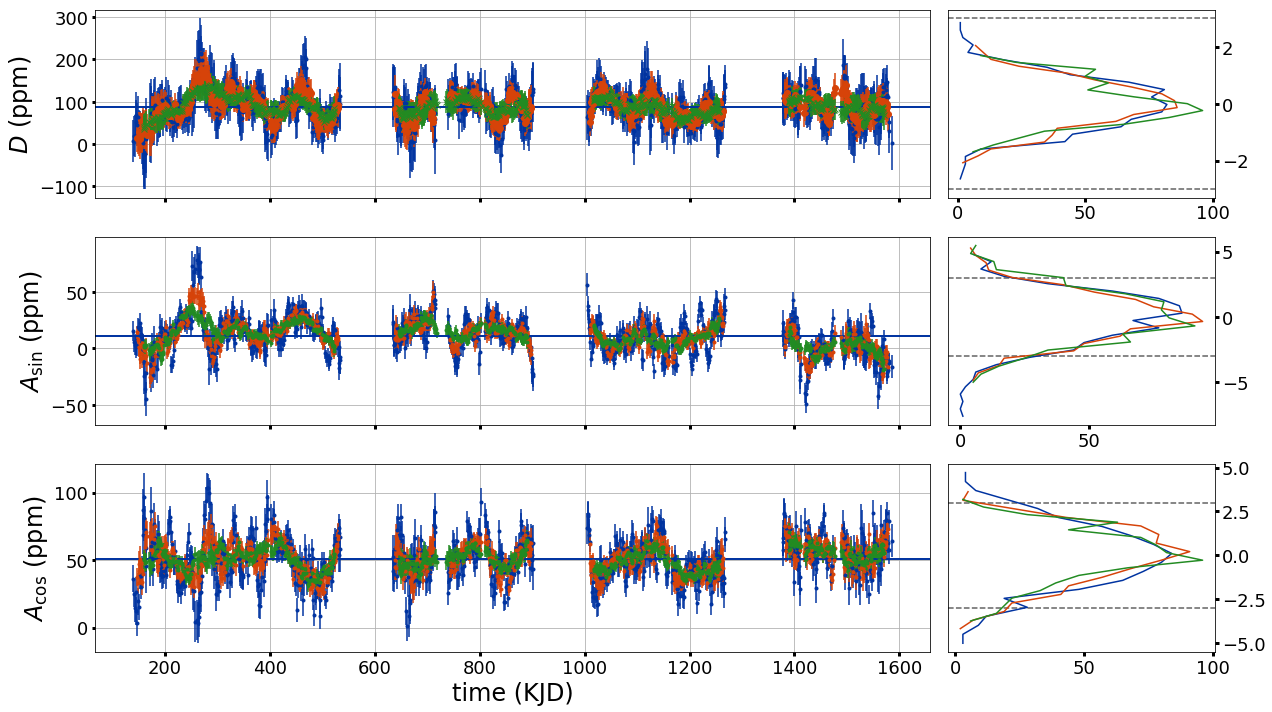

In [52]:
# Look at planetary phase curve
num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']
markers = ['.', 'o', 'x']

fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 4), (1, 0), colspan=3, sharex=ax1)
ax3 = plt.subplot2grid((3, 4), (2, 0), colspan=3, sharex=ax1)

ax1a = plt.subplot2grid((3, 4), (0, 3))
ax2a = plt.subplot2grid((3, 4), (1, 3))
ax3a = plt.subplot2grid((3, 4), (2, 3))

for i in range(len(num_orbits_arr)):
# for i in [2]:
    num_orbits = num_orbits_arr[i]
    color = colors[i]
    marker = markers[i]
    
    ret = stack_orbits(final_best_fit_transit_params['per'], filtered_time, 
                       num_orbits=num_orbits, min_orbits_to_fold=np.ceil(num_orbits/2))
    
    real_mid_times, real_BEER_and_eclipse_outs = fit_all_BEER_and_eclipse_params(ret)

    real_eclipse_depths, real_eclipse_depth_errs, real_Acoss, real_Acos_errs, real_Asins, real_Asin_errs =\
        collect_phase_curve_params(real_mid_times, real_BEER_and_eclipse_outs)
        
    make_phase_curve_plots(real_mid_times, real_eclipse_depths, real_eclipse_depth_errs, 
                           real_Acoss, real_Acos_errs, 
                           real_Asins, real_Asin_errs, 
                           ax1, ax2, ax3, ax1a, ax2a, ax3a, 
                           color=color, marker=marker)

    real_Aplanets, real_Aplanet_errs = calc_Aplanet(Abeam, Abeam_err, 
                                                    real_Asins, real_Asin_errs, 
                                                    real_Acoss, real_Acos_errs)
    real_phase_shifts, real_phase_shift_errs = calc_phase_shift(Abeam, Abeam_err, 
                                                                real_Asins, real_Asin_errs, 
                                                                real_Acoss, real_Acos_errs)
    
    print(np.min(real_Acoss), np.median(real_Acoss), np.max(real_Acoss),
          (np.median(real_Acoss) - np.min(real_Acoss))/np.median(real_Acoss), 
          (np.median(real_Acoss) - np.max(real_Acoss))/np.median(real_Acoss))

    print(np.min(real_Asins), np.median(real_Asins), np.max(real_Asins),
          (np.median(real_Asins) - np.min(real_Asins))/np.median(real_Asins), 
          (np.median(real_Asins) - np.max(real_Asins))/np.median(real_Asins))

    print(np.min(real_Aplanets), np.median(real_Aplanets), np.max(real_Aplanets),
          (np.median(real_Aplanets) - np.min(real_Aplanets))/np.median(real_Aplanets), 
          (np.median(real_Aplanets) - np.max(real_Aplanets))/np.median(real_Aplanets))

    print(np.min(real_phase_shifts)*180./np.pi, 
          np.median(real_phase_shifts)*180./np.pi, np.max(real_phase_shifts)*180./np.pi,
          (np.median(real_phase_shifts) - np.min(real_phase_shifts))/np.median(real_phase_shifts), 
          (np.median(real_phase_shifts) - np.max(real_phase_shifts))/np.median(real_phase_shifts))
    
fig.savefig("../planet-phase-curve-var_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

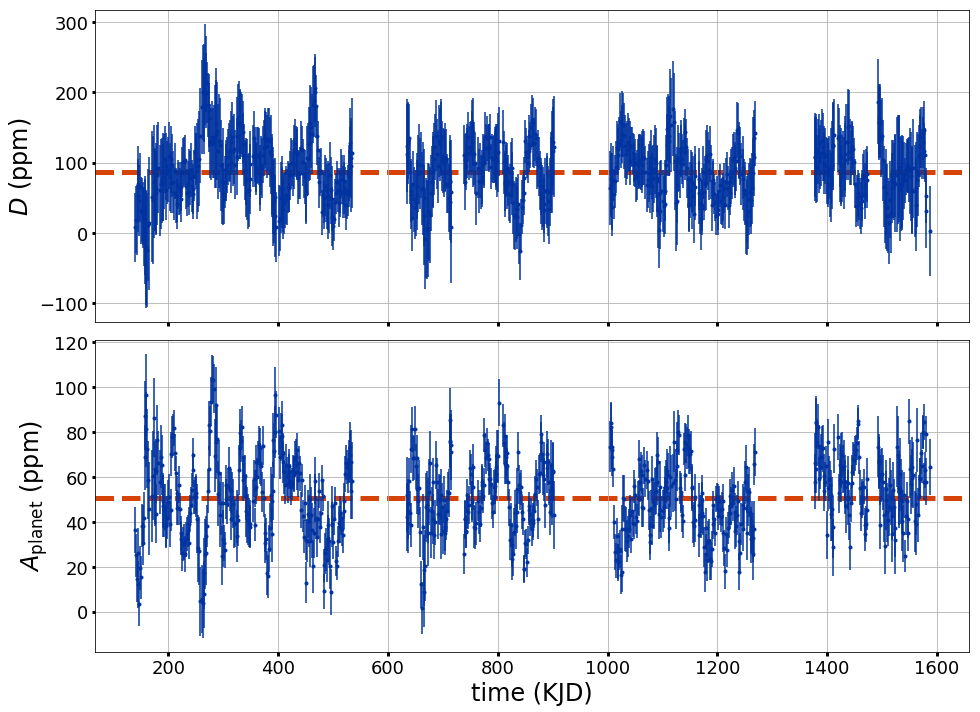

In [50]:
fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=3, sharex=ax1)

ax1.errorbar(real_mid_times, real_eclipse_depths*1e6, real_eclipse_depth_errs*1e6,
            ls='', color=color, marker='.')

ax2.errorbar(real_mid_times, real_Acoss*1e6, real_Acos_errs*1e6,
        ls='', color=color, marker='.')

ax1.tick_params('y', labelsize=18)
ax1.tick_params(labelbottom=False)
ax1.grid(True)
ax1.set_ylabel('$D$ (ppm)', fontsize=24)

ax2.grid(True)
ax2.tick_params('both', labelsize=18)
ax2.set_xlabel('time (KJD)', fontsize=24)
ax2.set_ylabel('$A_{\\rm planet}$ (ppm)', fontsize=24)

ax1.axhline(all_data_BEER_and_eclipse_out.params['eclipse_depth'].value*1e6, color=BoiseState_orange, lw=5, ls='--', 
           zorder=-1)
ax2.axhline(all_data_BEER_and_eclipse_out.params['Acos'].value*1e6, color=BoiseState_orange, lw=5, ls='--', 
           zorder=-1)

plt.tight_layout()

fig.savefig("../just-eclipse-Acos_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

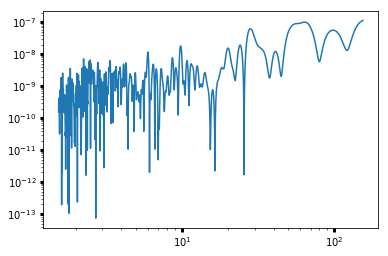

In [57]:
# Looking for period of variation

nout = 10000
sorted_real_mid_times = np.sort(real_mid_times)

min_freq = 1./(100.*final_best_fit_transit_params['per'])
max_freq = 1./final_best_fit_transit_params['per']
f = np.linspace(min_freq, max_freq, nout)
pgram = lombscargle(sorted_real_mid_times, real_Acoss, f)

plt.loglog(1./f, pgram)

CPU times: user 10.4 s, sys: 12.7 ms, total: 10.4 s
Wall time: 10.4 s
CPU times: user 14.4 s, sys: 71 ms, total: 14.4 s
Wall time: 14.4 s
CPU times: user 21.4 s, sys: 921 ms, total: 22.4 s
Wall time: 22.4 s


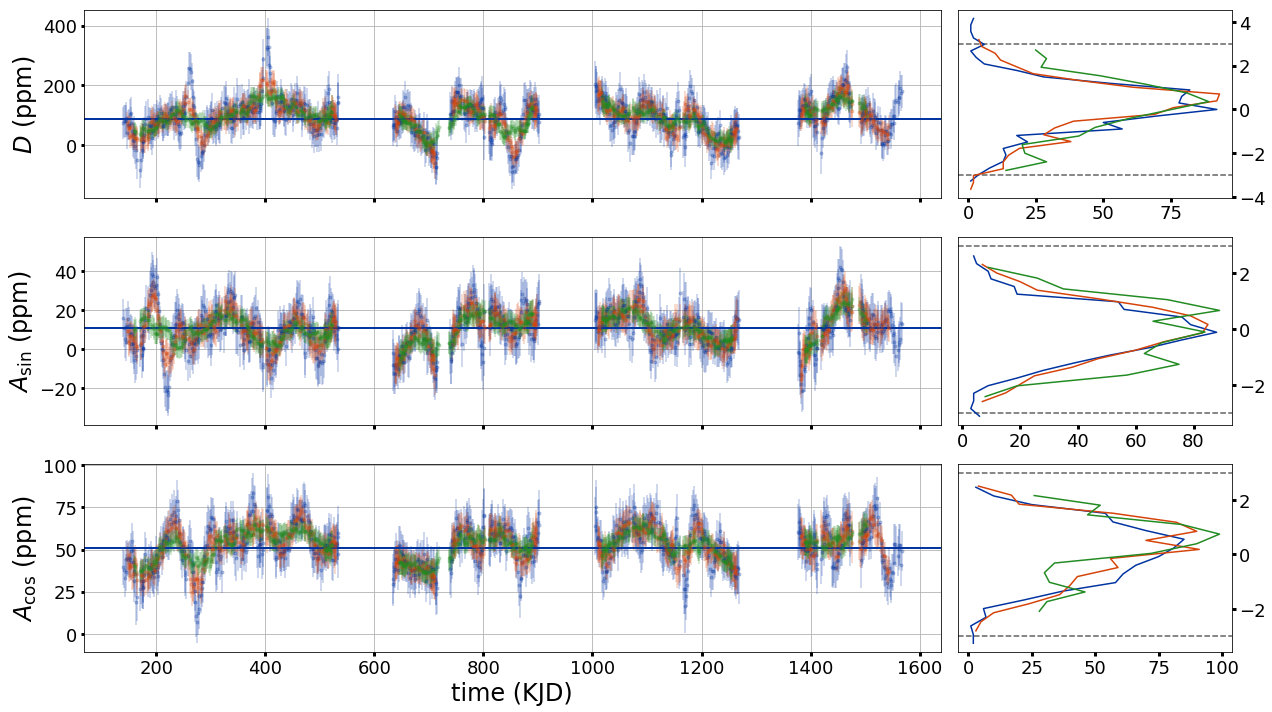

In [24]:
# Look at planetary phase curve using synthetic data!
synthetic_data = calc_BEER_curve(folded_time, all_data_BEER_and_eclipse_out.params) +\
                    noise*np.random.randn(folded_time.size)

# Look at planetary phase curve
fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 4), (1, 0), colspan=3, sharex=ax1)
ax3 = plt.subplot2grid((3, 4), (2, 0), colspan=3, sharex=ax1)

ax1a = plt.subplot2grid((3, 4), (0, 3))
ax2a = plt.subplot2grid((3, 4), (1, 3))
ax3a = plt.subplot2grid((3, 4), (2, 3))

num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']

for i in range(len(num_orbits_arr)):
    num_orbits = num_orbits_arr[i]
    color = colors[i]
    
    ret = stack_orbits(final_best_fit_transit_params['per'], filtered_time, 
                       num_orbits=num_orbits, min_orbits_to_fold=np.ceil(num_orbits/2))

    mid_times, BEER_and_eclipse_outs = fit_all_BEER_and_eclipse_params(ret,
                                                                       folded_time=folded_time, 
                                                                       filtered_flux=synthetic_data)

    eclipse_depths, eclipse_depth_errs, Acoss, Acos_errs, Asins, Asin_errs =\
        collect_phase_curve_params(mid_times, BEER_and_eclipse_outs)
            
    make_phase_curve_plots(mid_times, eclipse_depths, eclipse_depth_errs, Acoss, Acos_errs, Asins, Asin_errs, 
                           ax1, ax2, ax3, ax1a, ax2a, ax3a, 
                           color=color)

(40, 3.279526957808443e-06, 4.3005962107612975e-06, 6.213895602084057e-06)


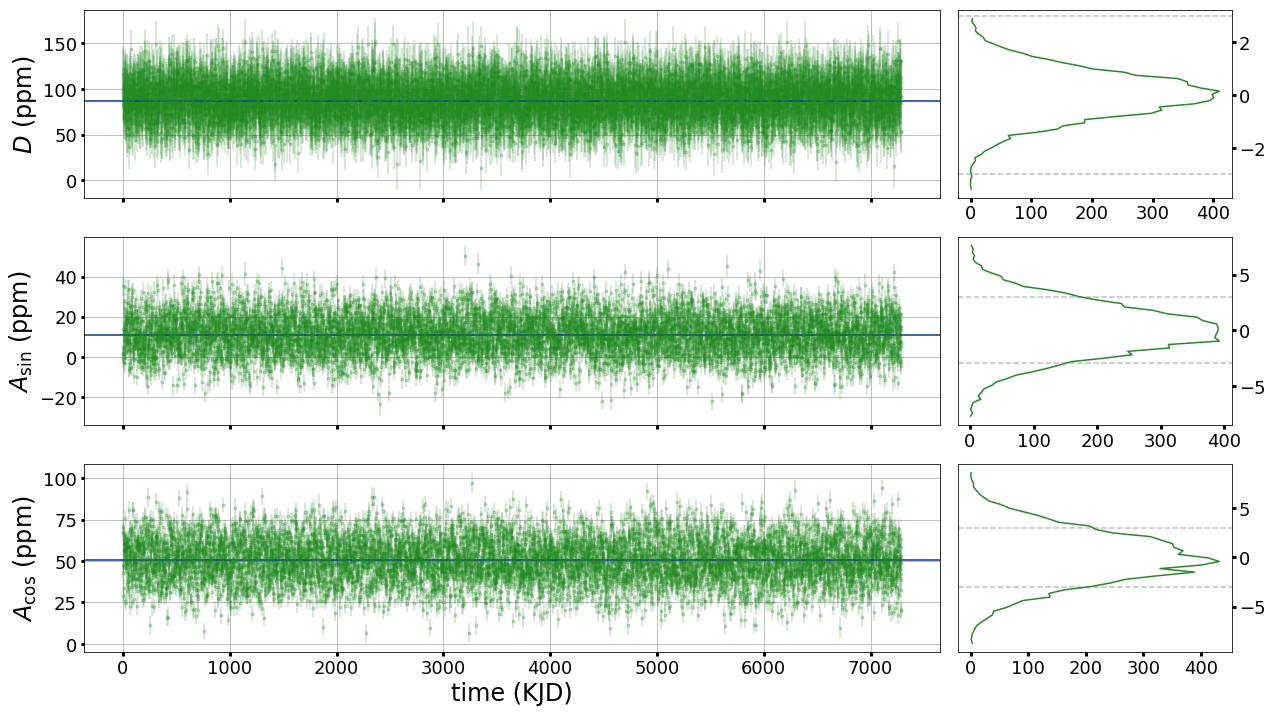

In [36]:
# 2018 Dec 29 - Scramble order of the orbits
single_orbit_ret = stack_orbits(final_best_fit_transit_params['per'], filtered_time, 
                                num_orbits=1, min_orbits_to_fold=0)

keys = single_orbit_ret.keys()
keys = [cur_key for cur_key in keys if ~np.isnan(cur_key)]
# number_of_orbits_to_stack = len(keys)

# Make lots of synthetic, scrambled stacks
number_of_orbits_to_stack = 10*len(keys)

num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']

fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 4), (1, 0), colspan=3, sharex=ax1)
ax3 = plt.subplot2grid((3, 4), (2, 0), colspan=3, sharex=ax1)

ax1a = plt.subplot2grid((3, 4), (0, 3))
ax2a = plt.subplot2grid((3, 4), (1, 3))
ax3a = plt.subplot2grid((3, 4), (2, 3))

# for i in range(len(num_orbits_arr)):
for i in [2]:
    num_orbits = num_orbits_arr[i]
    color = colors[i]
    
    # Build lists scrambled orbits
    ret = {}
    for j in range(number_of_orbits_to_stack):
        
        cur_list_of_orbits = [False]*len(filtered_time)
        for k in range(num_orbits):
            cur_list_of_orbits = cur_list_of_orbits | single_orbit_ret[np.random.choice(keys)]
        
        ret[j] = cur_list_of_orbits
  
    mid_times, scrambled_BEER_and_eclipse_outs = fit_all_BEER_and_eclipse_params(ret)

    scrambled_eclipse_depths, scrambled_eclipse_depth_errs, scrambled_Acoss, scrambled_Acos_errs, scrambled_Asins, scrambled_Asin_errs =\
        collect_phase_curve_params(mid_times, scrambled_BEER_and_eclipse_outs)
            
    print(num_orbits, np.min(scrambled_Asin_errs), np.median(scrambled_Asin_errs), np.max(scrambled_Asin_errs))
        
    make_phase_curve_plots(mid_times, scrambled_eclipse_depths, scrambled_eclipse_depth_errs, 
                           scrambled_Acoss, scrambled_Acos_errs, 
                           scrambled_Asins, scrambled_Asin_errs, 
                           ax1, ax2, ax3, ax1a, ax2a, ax3a, 
                           color=color)

In [10]:
%%cache Analysis_of_Kepler76b_numorbits40_2019Jan3.pkl scrambled_BEER_and_eclipse_outs
print("cached")

[Saved variables scrambled_BEER_and_eclipse_outs to file '/Users/bjackson/research/Active Projects/Searching-for-Variability-in-Eclipses-in-the-Kepler-Dataset/code/Analysis_of_Kepler76b_numorbits40_2019Jan3.pkl'.]
cached


In [133]:
# %%cache Analysis_of_Kepler76b_numorbits10_2018Dec31.pkl scrambled_BEER_and_eclipse_outs
# print("cached")

[Saved variables scrambled_BEER_and_eclipse_outs to file '/Users/bjackson/research/Active Projects/Searching-for-Variability-in-Eclipses-in-the-Kepler-Dataset/code/Analysis_of_Kepler76b_numorbits10_2018Dec31.pkl'.]
cached


2.7611931912382106
1.7683401629852846


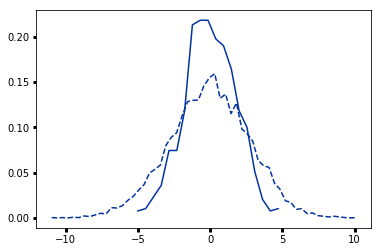

In [28]:
# 2019 Jan 3 - Comparing distributions
y = (scrambled_Acoss - all_data_BEER_and_eclipse_out.params['Acos'].value)/\
         np.sqrt(scrambled_Acos_errs**2 + all_data_BEER_and_eclipse_out.params['Acos'].stderr**2)
hst, edges = np.histogram(y, bins='auto', density=True)
bins = 0.5*(edges[1:] + edges[:-1])
plt.plot(bins, hst, color=BoiseState_blue, ls='--')
print(np.std(y))

y = (real_Acoss - all_data_BEER_and_eclipse_out.params['Acos'].value)/\
         np.sqrt(real_Acos_errs**2 + all_data_BEER_and_eclipse_out.params['Acos'].stderr**2)
hst, edges = np.histogram(y, bins='auto', density=True)
bins = 0.5*(edges[1:] + edges[:-1])
plt.plot(bins, hst, color=BoiseState_blue)
print(np.std(y))

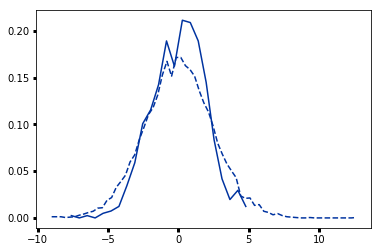

In [29]:
# 2019 Jan 3 - Comparing distributions
y = (scrambled_Asins - all_data_BEER_and_eclipse_out.params['Asin'].value)/\
         np.sqrt(scrambled_Asin_errs**2 + all_data_BEER_and_eclipse_out.params['Asin'].stderr**2)
hst, edges = np.histogram(y, bins='auto', density=True)
bins = 0.5*(edges[1:] + edges[:-1])
plt.plot(bins, hst, color=BoiseState_blue, ls='--')

y = (real_Asins - all_data_BEER_and_eclipse_out.params['Asin'].value)/\
         np.sqrt(real_Asin_errs**2 + all_data_BEER_and_eclipse_out.params['Asin'].stderr**2)
hst, edges = np.histogram(y, bins='auto', density=True)
bins = 0.5*(edges[1:] + edges[:-1])
plt.plot(bins, hst, color=BoiseState_blue)

In [134]:
print(ks_2samp(scrambled_eclipse_depths, real_eclipse_depths))
print(ks_2samp(scrambled_Acoss, real_Acoss))
print(ks_2samp(scrambled_Asins, real_Asins))

# Comparing real to scrambled phase curves with num_orbits_to_stack ~ 729
#
# For num_orbits = 10
# Ks_2sampResult(statistic=0.03956203048231366, pvalue=0.6129351515643384) - eclipse_depths
# Ks_2sampResult(statistic=0.1291983478297216, pvalue=9.377062507660279e-06) - Acoss
# Ks_2sampResult(statistic=0.10959497509205107, pvalue=0.0002927643175962688) - Asins
#
# For num_orbits = 20
# Ks_2sampResult(statistic=0.03580499143388771, pvalue=0.7395914554473048)
# Ks_2sampResult(statistic=0.15381749815193158, pvalue=6.711009600192165e-08)
# Ks_2sampResult(statistic=0.0749937427605194, pvalue=0.03344738724354831)
#
# For num_orbits = 40
# Ks_2sampResult(statistic=0.05501074292816854, pvalue=0.23416306885255225)
# Ks_2sampResult(statistic=0.14352388487179016, pvalue=9.226503369301734e-07)
# Ks_2sampResult(statistic=0.09071692435383993, pvalue=0.005884829403356939)

# Comparing real to scrambled phase curves with num_orbits_to_stack ~ 7290
#
# For num_orbits = 10
# Ks_2sampResult(statistic=0.02940695902632906, pvalue=0.6147601532460943)
# Ks_2sampResult(statistic=0.11926442704117887, pvalue=1.275813502851115e-08)
# Ks_2sampResult(statistic=0.0761784252704536, pvalue=0.0009067963673817769)
#
# For num_orbits = 40
# Ks_2sampResult(statistic=0.054627227547689006, pvalue=0.0492450442564559)
# Ks_2sampResult(statistic=0.14503975190071128, pvalue=9.13777968757148e-12)
# Ks_2sampResult(statistic=0.07052900999470521, pvalue=0.0041639490031135295)

Ks_2sampResult(statistic=0.02940695902632906, pvalue=0.6147601532460943)
Ks_2sampResult(statistic=0.11926442704117887, pvalue=1.275813502851115e-08)
Ks_2sampResult(statistic=0.0761784252704536, pvalue=0.0009067963673817769)


(2.5807955522229918e-05, 0.0002191372041634673, 3.3097910232591664e-05)


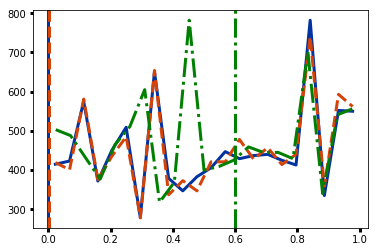

In [136]:
# 2018 Dec 31 - Comparing num_orbits_to_stack = 7290, num_orbits = 40 results to themselves
num_comparisons = 10000

# eclipse_depths_ks_scores = np.zeros(num_comparisons)
# Acoss_ks_scores = np.zeros(num_comparisons)
# Asins_ks_scores = np.zeros(num_comparisons)

# for i in range(num_comparisons):
#     Acoss_pop1 = np.random.choice(scrambled_Acoss, size=len(scrambled_Acoss)/10)
#     Acoss_pop2 = np.random.choice(scrambled_Acoss, size=len(scrambled_Acoss)/10)
#     Acoss_ks_scores[i] = ks_2samp(Acoss_pop1, Acoss_pop2).pvalue
    
#     Asins_pop1 = np.random.choice(scrambled_Asins, size=len(scrambled_Asins)/10)
#     Asins_pop2 = np.random.choice(scrambled_Asins, size=len(scrambled_Asins)/10)
#     Asins_ks_scores[i] = ks_2samp(Asins_pop1, Asins_pop2).pvalue
    
#     eclipse_depths_pop1 = np.random.choice(scrambled_eclipse_depths, size=len(scrambled_eclipse_depths)/10)
#     eclipse_depths_pop2 = np.random.choice(scrambled_eclipse_depths, size=len(scrambled_eclipse_depths)/10)
#     eclipse_depths_ks_scores[i] = ks_2samp(eclipse_depths_pop1, eclipse_depths_pop2).pvalue
    
print(np.min(Acoss_ks_scores), np.min(Asins_ks_scores), np.min(eclipse_depths_ks_scores))
    
hst, bin_edges = np.histogram(Acoss_ks_scores, bins='auto')
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
plt.plot(bins, hst, color=BoiseState_blue, lw=3)

# For num_orbits = 40
# plt.axvline(9e-12, color=BoiseState_blue, lw=3)

# For num_orbits = 10
plt.axvline(1e-8, color=BoiseState_blue, lw=3)

hst, bin_edges = np.histogram(Asins_ks_scores, bins='auto')
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
plt.plot(bins, hst, color=BoiseState_orange, lw=3, ls='--')
# plt.axvline(0.004, color=BoiseState_orange, lw=3, ls='--')
plt.axvline(0.0009, color=BoiseState_orange, lw=3, ls='--')

hst, bin_edges = np.histogram(eclipse_depths_ks_scores, bins='auto')
bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
plt.plot(bins, hst, color='green', lw=3, ls='-.')
# plt.axvline(0.05, color='green', lw=3, ls='-.')
plt.axvline(0.6, color='green', lw=3, ls='-.')

In [147]:
def fit_stacked_transits(ret, folded_time=folded_time, filtered_flux=filtered_flux, 
                         cur_noise=noise, transit_params=final_best_fit_transit_params, min_transit_points=0):

    mid_times = np.array([])
    stacked_transit_params = Parameters()

    stacked_transit_params.add('per', value=transit_params['per'], vary=False)
    stacked_transit_params.add('a', value=transit_params['a'], vary=False)
    stacked_transit_params.add('p', value=transit_params['p'], min=0., max=0.2)
    stacked_transit_params.add('b', value=transit_params['b'], vary=False)
    stacked_transit_params.add('T0', value=transit_params['T0'], vary=False)
    stacked_transit_params.add('baseline', value=transit_params['baseline'], min=-1000e-6, max=1000e-6)
    stacked_transit_params.add('linLimb', value=transit_params['linLimb'], vary=False)
    stacked_transit_params.add('quadLimb', value=transit_params['quadLimb'], vary=False)

    stacked_transits_outs = {}

    for cur_key in ret.keys():
        time = folded_time[ret[cur_key]]
        data = filtered_flux[ret[cur_key]]

        # Grab the transit portion
        ind = transit_indices(time, 2.*new_duration, transit_params['T0'])
        time = time[ind]
        data = data[ind]
        err = cur_noise*np.ones_like(time)

        # And then check that there ARE points in eclipse
        ind = transit_indices(time, new_duration, transit_params['T0'])
        if(time[ind].size <= min_transit_points):
            continue
        
        cur_transits_outs = minimize(residuals, stacked_transit_params, args=(time, data), 
                                 kws={'eps_data': err, 'model_to_use': fit_transit})

        for another_key in cur_transits_outs.params.keys():
            cur_transits_outs.params[another_key].stderr *= np.sqrt(cur_transits_outs.redchi)

        mid_times = np.append(mid_times, cur_key)
        stacked_transits_outs[cur_key] = cur_transits_outs

    return mid_times, stacked_transits_outs

In [167]:
help(fit_line)

Help on function fit_line in module __main__:

fit_line(params, x, y, err=1.0)



[-0.8692883   0.08483848]
[1.50882913e+00 7.81463726e-05]


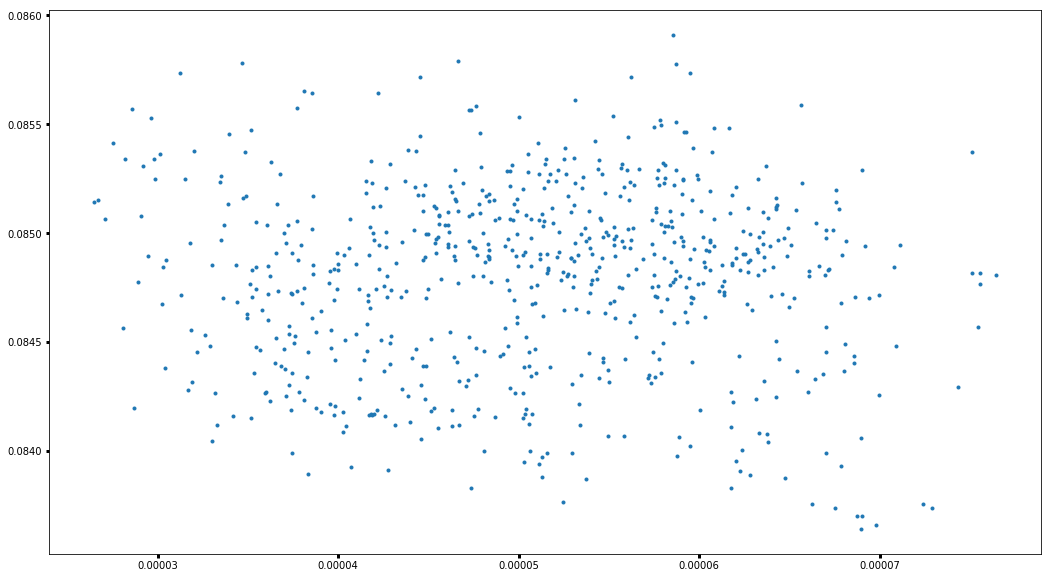

In [177]:
# 2019 Jan 1 - Fitting stacked transits and checking for any correlation between the transit and the Acos-values

num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']

fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = fig.add_subplot(111)

# for i in range(len(num_orbits_arr)):
for i in [1]:
    num_orbits = num_orbits_arr[i]
    color = colors[i]
       
    ret = stack_orbits(final_best_fit_transit_params['per'], filtered_time, 
                       num_orbits=num_orbits, min_orbits_to_fold=np.ceil(num_orbits/2))
  
    mid_times, stacked_transits_out = fit_stacked_transits(ret)
    
    transit_depths = np.array([stacked_transits_out[cur_key].params['p'].value for cur_key in mid_times])
    transit_depth_errs = np.array([stacked_transits_out[cur_key].params['p'].stderr for cur_key in mid_times])
    
# Check for correlation

# Toss big outliers first
Acos_med = np.median(real_Acoss)
Acos_std = mad(real_Acoss)
transit_depth_med = np.median(transit_depths)
transit_depth_std = mad(transit_depths)
ind =  (np.abs(transit_depths - transit_depth_med)/transit_depth_std <= 3) &\
       (np.abs(real_Acoss - Acos_med)/Acos_std <= 3) 

ax1.plot(real_Acoss[ind], transit_depths[ind], marker='.', ls='')

coeffs, cov = np.polyfit(real_Acoss[ind], transit_depths[ind], 1, cov=True)
print(coeffs)
print(np.sqrt(cov.diagonal()))

# No robust linear correlation!
#
# To reproduce these results, you'll need to run the real phase curve fitting cell above,
#   one num_orbit-value at a time, then come down here and run this cell for the same num_orbit-value.
#   Inefficient, but effective.


# For num_orbits = 10
# [1.46187415 0.08473942]
# [1.28713491e+00 6.83780783e-05]
#
# For num_orbits = 20
# [-0.8692883   0.08483848]
# [1.50882913e+00 7.81463726e-05]
#
# For num_orbits = 40 - 2.3-sigma negative correlation
# [-3.70116031  0.08497974]
# [1.58130010e+00 8.07185672e-05]

299.9872238327807
Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Acos           4.975e-05   -0.001    0.001 1.104e-05     True     None     None
Aellip         4.243e-06   -0.001    0.001 1.066e-05     True     None     None
Asin           2.434e-06   -0.001    0.001 9.612e-06     True     None     None
T0                0.685     -inf      inf     None    False     None     None
a                 5.103     -inf      inf     None    False     None     None
b                0.9078     -inf      inf     None    False     None     None
baseline       4.699e-06   -0.001    0.001 7.07e-06     True     None     None
eclipse_depth  5.166e-05   -0.001    0.001 5.137e-05     True     None     None
noise          0.000177        0    0.001 5.045e-06     True     None     None
per               1.545     -inf      inf     None    False     None     None
None


('baseline', 7.177507645867951)
('Aellip', 10.892926169449712)
('Asin', 11.14394218341181)
('Acos', 12.40

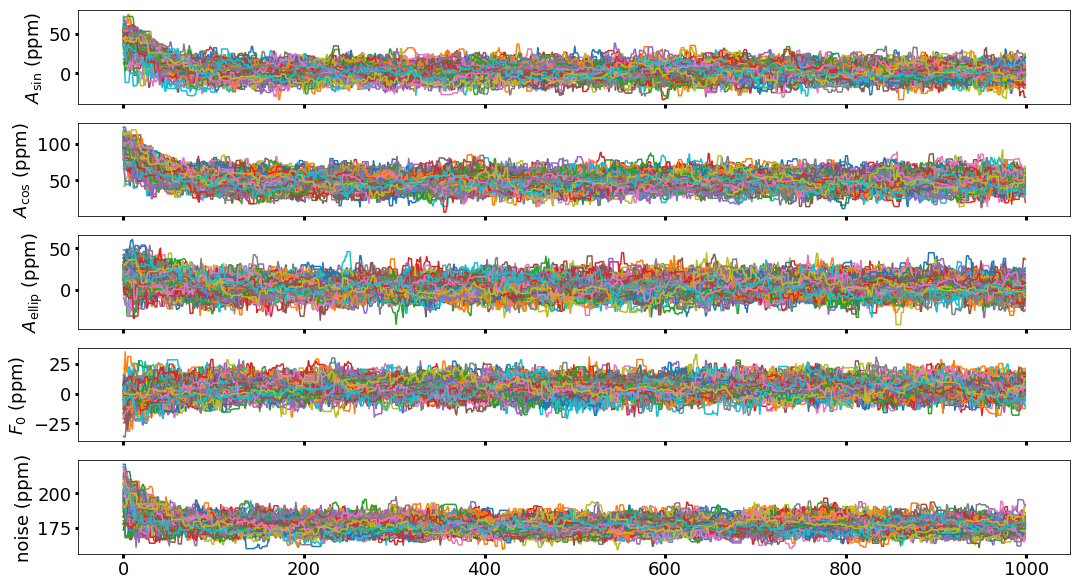

In [34]:
# 2018 Jan 2 - Fit some orbits using MCMC

num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']

fig = plt.figure(figsize=(aspect_ratio*10, 10))

# for i in range(len(num_orbits_arr)):
for i in [0]:
    num_orbits = num_orbits_arr[i]
    color = colors[i]
    
    ret = stack_orbits(final_best_fit_transit_params['per'], filtered_time, 
                       num_orbits=num_orbits, min_orbits_to_fold=np.ceil(num_orbits/2))
    
    # Just one stacked set of orbits
    key_to_try = 2
    ret = {ret.keys()[key_to_try]: ret[ret.keys()[key_to_try]]}
    
    nwalkers = 100
    nsteps = 1000
    burn = 500
    
    mid_times, one_stacked_BEER_and_eclipse_outs = fit_all_BEER_and_eclipse_params(ret, use_MCMC=True) 
    
    for cur_key in one_stacked_BEER_and_eclipse_outs.keys():
        print(cur_key)
        print(one_stacked_BEER_and_eclipse_outs[cur_key].params.pretty_print())

        for another_key in ['baseline', 'Aellip', 'Asin', 'Acos', 'eclipse_depth', 'noise']:
            print(another_key, np.std(one_stacked_BEER_and_eclipse_outs[cur_key].flatchain[another_key][burn:])*1e6)        
            
    ax1 = fig.add_subplot(511)
    ax1.plot(np.array(one_stacked_BEER_and_eclipse_outs[cur_key].flatchain['Asin']*1e6).reshape((nwalkers, nsteps)).transpose())
    ax1.tick_params(labelbottom=False, labelsize=18)
    ax1.set_ylabel('$A_{\\rm sin}$ (ppm)', fontsize=18)

    ax2 = fig.add_subplot(512)
    ax2.plot(np.array(one_stacked_BEER_and_eclipse_outs[cur_key].flatchain['Acos']*1e6).reshape((nwalkers, nsteps)).transpose())
    ax2.tick_params(labelbottom=False, labelsize=18)
    ax2.set_ylabel('$A_{\\rm cos}$ (ppm)', fontsize=18)

    ax3 = fig.add_subplot(513, sharex=ax1)
    ax3.plot(np.array(one_stacked_BEER_and_eclipse_outs[cur_key].flatchain['Aellip']*1e6).reshape((nwalkers, nsteps)).transpose())
    ax3.tick_params(labelbottom=False, labelsize=18)
    ax3.set_ylabel('$A_{\\rm ellip}$ (ppm)', fontsize=18)

    ax4 = fig.add_subplot(514)
    ax4.plot(np.array(one_stacked_BEER_and_eclipse_outs[cur_key].flatchain['baseline']*1e6).reshape((nwalkers, nsteps)).transpose())
    ax4.tick_params(labelbottom=False, labelsize=18)
    ax4.set_ylabel('$F_0$ (ppm)', fontsize=18)

    ax5 = fig.add_subplot(515)
    ax5.plot(np.array(one_stacked_BEER_and_eclipse_outs[cur_key].flatchain['noise']*1e6).reshape((nwalkers, nsteps)).transpose())
    ax5.tick_params(labelsize=18)
    ax5.set_ylabel('noise (ppm)', fontsize=18)

# 809.6904307584773
# Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
# Acos           8.313e-05   -0.001    0.001 1.235e-05     True     None     None
# Aellip         3.104e-05   -0.001    0.001 1.235e-05     True     None     None
# Asin           1.633e-05   -0.001    0.001 1.083e-05     True     None     None
# T0                0.685     -inf      inf     None    False     None     None
# a                 5.103     -inf      inf     None    False     None     None
# b                0.9078     -inf      inf     None    False     None     None
# baseline       2.319e-05   -0.001    0.001 8.687e-06     True     None     None
# eclipse_depth  0.0001223   -0.001    0.001 6.284e-05     True     None     None
# noise          0.0001602        0    0.001 5.787e-06     True     None     None
# per               1.545     -inf      inf     None    False     None     None
# None
#
# Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
# Acos           8.307e-05   -0.001    0.001 1.086e-05     True     None     None
# Aellip         3.069e-05   -0.001    0.001 1.101e-05     True     None     None
# Asin           1.568e-05   -0.001    0.001 9.647e-06     True     None     None
# T0                0.685     -inf      inf        0    False     None     None
# a                 5.103     -inf      inf        0    False     None     None
# b                0.9078     -inf      inf        0    False     None     None
# baseline       2.418e-05   -0.001    0.001 7.312e-06     True     None     None
# eclipse_depth  0.0001289   -0.001    0.001 5.147e-05     True     None     None
# per               1.545     -inf      inf        0    False     None     None

# 890.5498077886368
# Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
# Acos           7.085e-05   -0.001    0.001 1.161e-05     True     None     None
# Aellip         7.137e-07   -0.001    0.001 1.18e-05     True     None     None
# Asin           1.893e-05   -0.001    0.001 1.032e-05     True     None     None
# T0                0.685     -inf      inf     None    False     None     None
# a                 5.103     -inf      inf     None    False     None     None
# b                0.9078     -inf      inf     None    False     None     None
# baseline       6.438e-06   -0.001    0.001 7.502e-06     True     None     None
# eclipse_depth  5.686e-05   -0.001    0.001 5.528e-05     True     None     None
# noise          0.0001825        0    0.001 5.179e-06     True     None     None
# per               1.545     -inf      inf     None    False     None     None
# None
#
# ('baseline', 7.584244723807445)
# ('Aellip', 11.835817972450986)
# ('Asin', 10.674996603407292)
# ('Acos', 11.798462508758572)
# ('eclipse_depth', 54.696621029924266)
# ('noise', 5.36855690413748)

# 299.9872238327807
# Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
# Acos           4.975e-05   -0.001    0.001 1.104e-05     True     None     None
# Aellip         4.243e-06   -0.001    0.001 1.066e-05     True     None     None
# Asin           2.434e-06   -0.001    0.001 9.612e-06     True     None     None
# T0                0.685     -inf      inf     None    False     None     None
# a                 5.103     -inf      inf     None    False     None     None
# b                0.9078     -inf      inf     None    False     None     None
# baseline       4.699e-06   -0.001    0.001 7.07e-06     True     None     None
# eclipse_depth  5.166e-05   -0.001    0.001 5.137e-05     True     None     None
# noise          0.000177        0    0.001 5.045e-06     True     None     None
# per               1.545     -inf      inf     None    False     None     None
# None
#
# ('baseline', 7.177507645867951)
# ('Aellip', 10.892926169449712)
# ('Asin', 11.14394218341181)
# ('Acos', 12.402731485967037)
# ('eclipse_depth', 50.83677122361694)
# ('noise', 5.543997058536265)

# And the chains look pretty converged - the analysis from earlier said the correlation times were all < 80.

In [71]:
# 2018 Jan 7 - Generate synthetic data

quarters = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
# quarters = [13]

BEER_plus_filter_flux = np.array([])
all_returned_filters = np.array([])

quarter_start_end = {}

for cur_quarter in quarters:

    cur_unfiltered_time, cur_unfiltered_flux, cur_filtered_time, cur_filtered_flux, cur_returned_filter =\
        retreive_data(num_periods=num_periods, KIC=K76.KIC, params=final_best_fit_transit_params, drop_outliers=True, 
                     which_quarters=[cur_quarter])
    folded_time = cur_filtered_time % line_out.params['slope'].value

    quarter_start_end[cur_quarter] = np.array([np.min(cur_unfiltered_time), np.max(cur_unfiltered_time)])
    
    injection_data = np.ones_like(cur_unfiltered_time)
    
    # 2019 Jan 4 - Injection and recovery test
    single_orbit_ret = stack_orbits(final_best_fit_transit_params['per'], cur_unfiltered_time, 
                                    num_orbits=1, min_orbits_to_fold=0)

    # Generate interpolated values for eclipse_depth, Asin, and Acos
    injection_BEER_and_eclipse_params = {'per': final_best_fit_transit_params['per'],
                                         'a': final_best_fit_transit_params['a'],
                                         'b': final_best_fit_transit_params['b'],
                                         'T0': final_best_fit_transit_params['T0'],
                                         'baseline': 1.,
                                         'Aellip': all_data_BEER_and_eclipse_out.params['Aellip'], 
                                         'eclipse_depth': all_data_BEER_and_eclipse_out.params['eclipse_depth'],
                                         'Asin': all_data_BEER_and_eclipse_out.params['Asin'],
                                         'Acos': all_data_BEER_and_eclipse_out.params['Acos']}

    # real_eclipse_depths, real_eclipse_depth_errs, real_Acoss, real_Acos_errs, real_Asins, real_Asin_errs
    ind = np.argsort(ret.keys())
    saved_real_mid_times = np.array(ret.keys())[ind]
    saved_real_eclipse_depths = real_eclipse_depths[ind]
    saved_real_Asins = real_Asins[ind]
    saved_real_Acoss = real_Acoss[ind]

    for cur_key in single_orbit_ret.keys():
        cur_eclipse_depth = np.interp(cur_key, saved_real_mid_times, saved_real_eclipse_depths)
        cur_Asin = np.interp(cur_key, saved_real_mid_times, saved_real_Asins)
        cur_Acos = np.interp(cur_key, saved_real_mid_times, saved_real_Acoss)

        injection_BEER_and_eclipse_params['eclipse_depth'] =\
            np.interp(cur_key, saved_real_mid_times, saved_real_eclipse_depths)
        injection_BEER_and_eclipse_params['Asin'] =\
            np.interp(cur_key, saved_real_mid_times, saved_real_Asins)
        injection_BEER_and_eclipse_params['Acos'] =\
            np.interp(cur_key, saved_real_mid_times, saved_real_Acoss)

        injection_data[single_orbit_ret[cur_key]] =\
            calc_BEER_curve(cur_unfiltered_time[single_orbit_ret[cur_key]],
                            injection_BEER_and_eclipse_params)*cur_returned_filter[single_orbit_ret[cur_key]]
        
    BEER_plus_filter_flux = np.append(BEER_plus_filter_flux, injection_data)
    all_returned_filters = np.append(all_returned_filters, cur_returned_filter)
    
unBEERed_data = unfiltered_flux - BEER_plus_filter_flux + all_returned_filters

(62900, 63000)

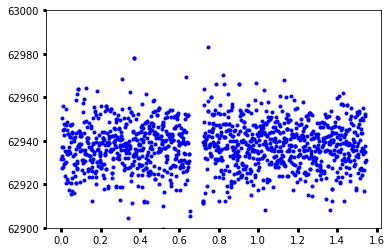

In [61]:
# Subtract out the BEER and eclipse signals - Don't worry about the transit because we'll ignore it anyway.

# plt.plot(bintime, binflux, 'b.')
# plt.axvline(final_best_fit_transit_params['T0'] + 0.5*final_best_fit_transit_params['per'])
# plt.ylim([-20, 20])

# No obvious signs of the BEER signals or eclipse
unBEERed_data = cur_unfiltered_flux - BEER_plus_filter_flux + all_returned_filters
# synthetic_data = unfiltered_flux - all_returned_filters

bintime, binflux, binerr = bindata(cur_unfiltered_time % final_best_fit_transit_params['per'], unBEERed_data, 
                                  binsize=1./60./24.)

# plt.plot(unfiltered_time, unfiltered_flux, 'r.')
# plt.plot(unfiltered_time, BEER_plus_filter_flux, 'b.')
# plt.plot(unfiltered_time, all_returned_filters, 'k.', alpha=0.1)
# plt.ylim([63300, 63500])

# plt.plot(unfiltered_time, synthetic_data, 'r.')
# plt.xlim([630, 630 + 6.*4.*final_best_fit_transit_params['per']])
# plt.ylim([-300, 100])

plt.plot(bintime, binflux, 'b.')
plt.ylim([62900, 63000])

# 2019 Jan 9 - Just Quarter 13 shown below!

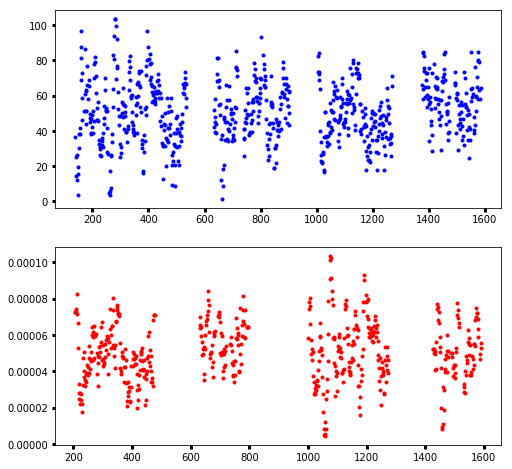

In [105]:
# 2019 Jan 9 - Shift the phase of the BEER signal parameters

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax1.plot(real_mid_times, real_Acoss*1e6, 'b.')

ax2 = fig.add_subplot(212)

single_orbit_ret = stack_orbits(final_best_fit_transit_params['per'], unfiltered_time, 
                                num_orbits=1, min_orbits_to_fold=0)

# Generate interpolated values for eclipse_depth, Asin, and Acos
injection_BEER_and_eclipse_params = {'per': final_best_fit_transit_params['per'],
                                     'a': final_best_fit_transit_params['a'],
                                     'b': final_best_fit_transit_params['b'],
                                     'T0': final_best_fit_transit_params['T0'],
                                     'baseline': 1.,
                                     'Aellip': all_data_BEER_and_eclipse_out.params['Aellip'], 
                                     'eclipse_depth': all_data_BEER_and_eclipse_out.params['eclipse_depth'],
                                     'Asin': all_data_BEER_and_eclipse_out.params['Asin'],
                                     'Acos': all_data_BEER_and_eclipse_out.params['Acos']}

# real_eclipse_depths, real_eclipse_depth_errs, real_Acoss, real_Acos_errs, real_Asins, real_Asin_errs
ind = np.argsort(ret.keys())
saved_real_mid_times = np.array(ret.keys())[ind]
saved_real_eclipse_depths = real_eclipse_depths[ind]
saved_real_Asins = real_Asins[ind]
saved_real_Acoss = real_Acoss[ind]

synthetic_time = np.array([])
synthetic_flux = np.array([])

synthetic_midtimes = {}
# Where the original mid-time came from
original_synthetic_midtimes = {}

all_single_orbit_mid_times = single_orbit_ret.keys()
for cur_key in all_single_orbit_mid_times:
    
    # Shift half way around the total timespan 
    new_approx_mid_time = (cur_key + 0.5*np.max(unfiltered_time)) % np.max(unfiltered_time)
    
    # If you don't find a mid-time near where you're looking, don't include that data point
    mn_ind = np.argmin(np.abs(all_single_orbit_mid_times - new_approx_mid_time))
    if(~(np.abs(all_single_orbit_mid_times[mn_ind] - new_approx_mid_time) <= final_best_fit_transit_params['per'])):
        continue
    
    new_mid_time = all_single_orbit_mid_times[np.argmin(np.abs(all_single_orbit_mid_times - new_approx_mid_time))]
    
    synthetic_midtimes[new_mid_time] = single_orbit_ret[cur_key]
    original_synthetic_midtimes[new_mid_time] = cur_key
    
    cur_eclipse_depth = np.interp(cur_key, saved_real_mid_times, saved_real_eclipse_depths)
    cur_Asin = np.interp(cur_key, saved_real_mid_times, saved_real_Asins)
    cur_Acos = np.interp(cur_key, saved_real_mid_times, saved_real_Acoss)
    
    injection_BEER_and_eclipse_params['eclipse_depth'] =\
        np.interp(cur_key, saved_real_mid_times, saved_real_eclipse_depths)
    injection_BEER_and_eclipse_params['Asin'] =\
        np.interp(cur_key, saved_real_mid_times, saved_real_Asins)
    injection_BEER_and_eclipse_params['Acos'] =\
        np.interp(cur_key, saved_real_mid_times, saved_real_Acoss)
    
    ax2.plot(new_mid_time, injection_BEER_and_eclipse_params['Acos'], 'r.')

    injection_data =\
        calc_BEER_curve(unfiltered_time[single_orbit_ret[new_mid_time]],
                        injection_BEER_and_eclipse_params)*unBEERed_data[single_orbit_ret[new_mid_time]]

    synthetic_time = np.append(synthetic_time, unfiltered_time[single_orbit_ret[new_mid_time]])
    synthetic_flux = np.append(synthetic_flux, injection_data)

(0, array([131.51235189, 164.98401443]))
(1, array([169.76562512, 258.46793425]))
(2, array([260.24561952, 349.4954674 ]))
(3, array([352.39693547, 442.20254007]))
(4, array([443.5103148 , 538.16292489]))
(5, array([630.19596643, 719.54801989]))
(6, array([735.38350476, 802.34436822]))
(7, array([808.53589548, 905.92670969]))
(8, array([1001.22928766, 1098.32536949]))
(9, array([1099.42874546, 1182.02129873]))
(10, array([1182.75687832, 1273.05697721]))
(11, array([1373.50901998, 1471.13636601]))
(12, array([1472.11713285, 1557.95875369]))
(13, array([1559.24606744, 1591.0012262 ]))


(200, 400)

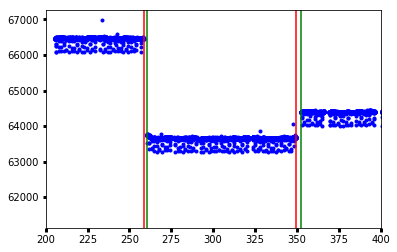

In [78]:
plt.plot(synthetic_time, synthetic_flux, 'b.')

for cur_key in quarter_start_end.keys():
    print(cur_key, quarter_start_end[cur_key])
    plt.axvline(quarter_start_end[cur_key][0], color='green')
    plt.axvline(quarter_start_end[cur_key][1], color='red')
    
plt.xlim([200, 400])

(-0.00025, 0.00025)

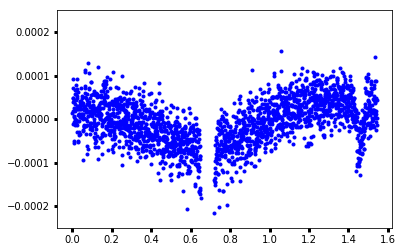

In [98]:
# Filter synthetic data, one quarter at a time

filtered_synthetic_time = np.array([])
filtered_synthetic_flux = np.array([])

for cur_key in quarter_start_end.keys():
    ind = (synthetic_time >= quarter_start_end[cur_key][0]) & (synthetic_time <= quarter_start_end[cur_key][1])
    
    if(synthetic_time[ind].size == 0):
        continue
    
    cur_time = synthetic_time[ind]
    cur_flux = synthetic_flux[ind]
    
    cur_filtered_synthetic_time, cur_filtered_synthetic_flux, _ =\
        filter_data(cur_time, cur_flux, num_periods=num_periods, params=final_best_fit_transit_params)
    
    filtered_synthetic_time = np.append(filtered_synthetic_time, cur_filtered_synthetic_time)
    filtered_synthetic_flux = np.append(filtered_synthetic_flux, cur_filtered_synthetic_flux)
    
folded_synthetic_time = filtered_synthetic_time % final_best_fit_transit_params['per']
binned_time, binned_data, binned_err = bindata(folded_synthetic_time, 
                                               filtered_synthetic_flux, binsize=1./60./24.)
plt.plot(binned_time, binned_data, 'b.')
plt.ylim([-0.00025, 0.00025])

(204.90194406403316, 209.64157806587173, 1587.4951194737769, 1590.4699272087382)


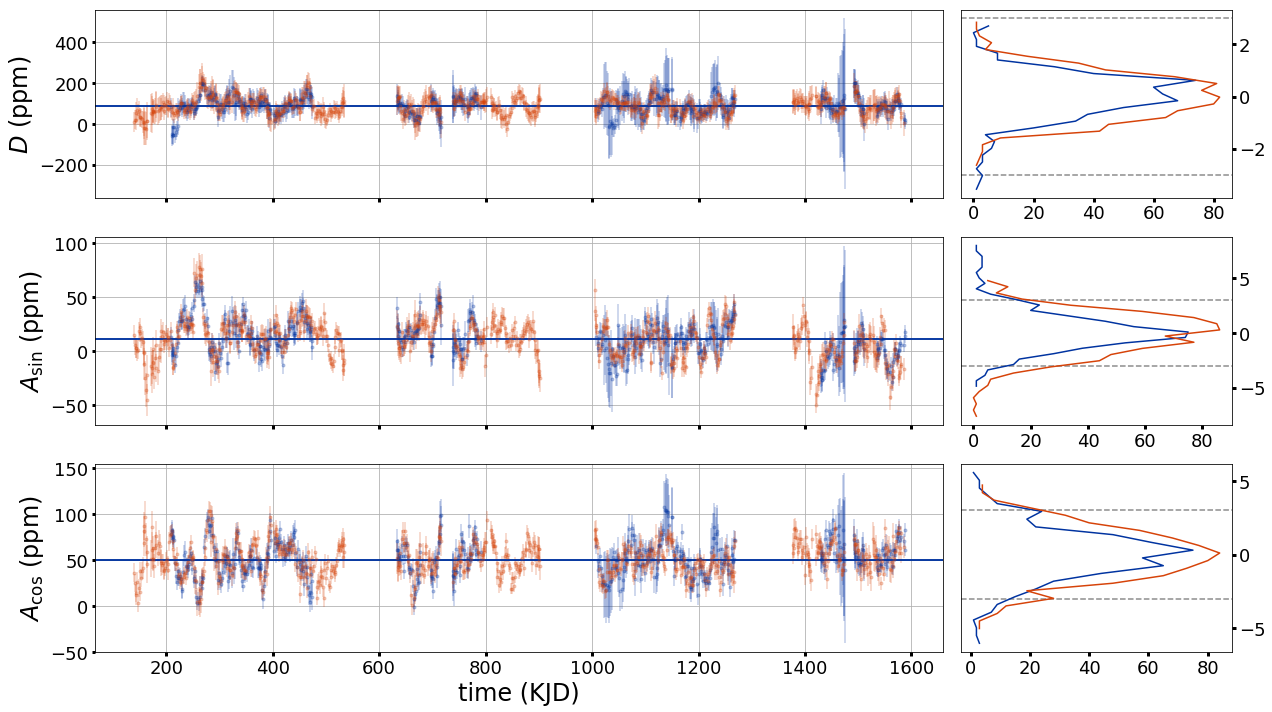

In [124]:
# 2019 Jan 9 - The resulting plot compares the BEER signal parameters using the synthetic dataset above
#   to what they *should* be based on the real data.
num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']

fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 4), (1, 0), colspan=3, sharex=ax1)
ax3 = plt.subplot2grid((3, 4), (2, 0), colspan=3, sharex=ax1)

ax1a = plt.subplot2grid((3, 4), (0, 3))
ax2a = plt.subplot2grid((3, 4), (1, 3))
ax3a = plt.subplot2grid((3, 4), (2, 3))

for i in range(len(num_orbits_arr)):
# for i in [0]:
    num_orbits = num_orbits_arr[i]
    color = colors[i]
    
    ret = stack_orbits(final_best_fit_transit_params['per'], filtered_synthetic_time, 
                       num_orbits=num_orbits, min_orbits_to_fold=np.ceil(num_orbits/2))
    
    synthetic_mid_times, synthetic_BEER_and_eclipse_outs = fit_all_BEER_and_eclipse_params(ret,
                                                                       folded_time=folded_synthetic_time, 
                                                                       filtered_flux=filtered_synthetic_flux)   
    synthetic_eclipse_depths, synthetic_eclipse_depth_errs,\
    synthetic_Acoss, synthetic_Acos_errs,\
    synthetic_Asins, synthetic_Asin_errs =\
        collect_phase_curve_params(synthetic_mid_times, synthetic_BEER_and_eclipse_outs)        
        
    print(np.mean(synthetic_eclipse_depths) - np.mean(synthetic_eclipse_depths))    
    
    # Shift new synthetic_mid_times back around to original values
    synthetic_mid_times -= 0.5*np.max(unfiltered_time)
    synthetic_mid_times[synthetic_mid_times < np.min(real_mid_times)] += np.max(unfiltered_time)
    
    print(np.min(original_synthetic_midtimes.values()), np.min(synthetic_mid_times), 
          np.max(synthetic_mid_times), np.max(original_synthetic_midtimes.values()))

    make_phase_curve_plots(synthetic_mid_times, synthetic_eclipse_depths, synthetic_eclipse_depth_errs, 
                           synthetic_Acoss, synthetic_Acos_errs, 
                           synthetic_Asins, synthetic_Asin_errs, 
                           ax1, ax2, ax3, ax1a, ax2a, ax3a, 
                           color=color)

    make_phase_curve_plots(real_mid_times, real_eclipse_depths, real_eclipse_depth_errs, 
                           real_Acoss, real_Acos_errs, 
                           real_Asins, real_Asin_errs, 
                           ax1, ax2, ax3, ax1a, ax2a, ax3a, 
                           color=colors[i+1])

# fig.savefig("../planet-phase-curve-var-comparison-shifted_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

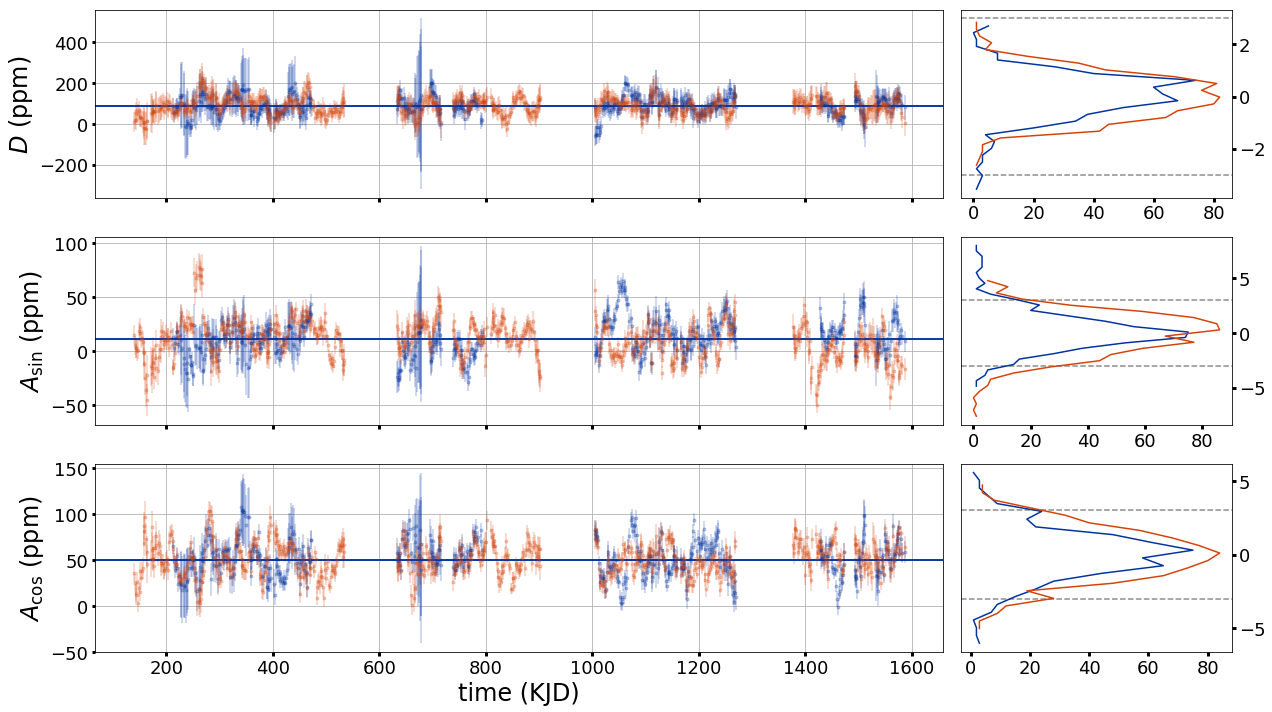

In [125]:
# 2019 Jan 9 - The resulting plot compares the BEER signal parameters using the synthetic dataset above
#   to what they *should* be based on the real data.
#
#   BUT in this case I have NOT re-shifted the synthetic back to the original mid-times. 
#
# In other words, we do NOT expect the blue and orange points to match up because they should be about 800 days
#   out of phase.

num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']

fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 4), (1, 0), colspan=3, sharex=ax1)
ax3 = plt.subplot2grid((3, 4), (2, 0), colspan=3, sharex=ax1)

ax1a = plt.subplot2grid((3, 4), (0, 3))
ax2a = plt.subplot2grid((3, 4), (1, 3))
ax3a = plt.subplot2grid((3, 4), (2, 3))

# for i in range(len(num_orbits_arr)):
for i in [0]:
    num_orbits = num_orbits_arr[i]
    color = colors[i]
    
    ret = stack_orbits(final_best_fit_transit_params['per'], filtered_synthetic_time, 
                       num_orbits=num_orbits, min_orbits_to_fold=np.ceil(num_orbits/2))
    
    synthetic_mid_times, synthetic_BEER_and_eclipse_outs = fit_all_BEER_and_eclipse_params(ret,
                                                                       folded_time=folded_synthetic_time, 
                                                                       filtered_flux=filtered_synthetic_flux)   
    synthetic_eclipse_depths, synthetic_eclipse_depth_errs,\
    synthetic_Acoss, synthetic_Acos_errs,\
    synthetic_Asins, synthetic_Asin_errs =\
        collect_phase_curve_params(synthetic_mid_times, synthetic_BEER_and_eclipse_outs)        
        
    make_phase_curve_plots(synthetic_mid_times, synthetic_eclipse_depths, synthetic_eclipse_depth_errs, 
                           synthetic_Acoss, synthetic_Acos_errs, 
                           synthetic_Asins, synthetic_Asin_errs, 
                           ax1, ax2, ax3, ax1a, ax2a, ax3a, 
                           color=color)

    make_phase_curve_plots(real_mid_times, real_eclipse_depths, real_eclipse_depth_errs, 
                           real_Acoss, real_Acos_errs, 
                           real_Asins, real_Asin_errs, 
                           ax1, ax2, ax3, ax1a, ax2a, ax3a, 
                           color=colors[i+1])

# fig.savefig("../planet-phase-curve-var-comparison-unshifted_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

('i: ', 0.12791524664885226, 79.74963436791951, 0.12232758731822037)
('qellip*1e3: ', 0.1974397614199169, 1.7068415878985732, 0.1934672082459321)
('qbeam_samples*1e3: ', 0.12347043474927855, 1.5905911863936042, 0.12465120544285341)
('pgeo: ', 0.2476682042131933)
Checking that eclipse depth and phase curve match up: 
1.1700034981179197


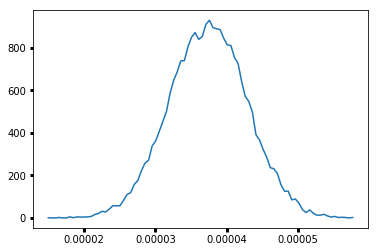

In [35]:
# 2019 Jan 14 - Exploring uncertainities on mass ratio and inclination
def qellip(Aellip, inc, a, alpha_ellip=1.02):
    return Aellip/alpha_ellip/np.sin(inc)**2*a*a*a

def convert_Kz_to_qbeam(Kz, Mstar, P, inc, Kz0=7.14e-4):
    # reflex velocity amplitude Kz in units of the speed of light
    # Mstar in solar units
    # P in days
    # inc in radians
    
    return (Kz/Kz0)*(Mstar)**(-1./3)*(P)**(1./3)/np.abs(np.sin(inc))

BEER_burn = 2500
Aellip_samples = np.random.choice(Aellip_chain[burn:,:].flatten(), 10*BEER_burn)

transit_burn = 16000
a_samples = np.random.choice(a_chain[transit_burn:,:].flatten(), 10*BEER_burn)
p_samples = np.random.choice(p_chain[transit_burn:,:].flatten(), 10*BEER_burn)
i_samples = np.arccos(np.random.choice(b_chain[transit_burn:,:].flatten(), 10*BEER_burn)/a_samples)

print("i: ",       
      (np.quantile(i_samples, 0.5) - np.quantile(i_samples, 0.16))*180./np.pi, 
      np.quantile(i_samples, 0.5)*180./np.pi, 
      (np.quantile(i_samples, 0.84) - np.quantile(i_samples, 0.5))*180./np.pi)

qellip_samples = qellip(Aellip_samples, i_samples, a_samples)

hst, edges = np.histogram(qellip_samples*1e3, bins='auto')
bins = 0.5*(edges[1:] + edges[:-1])
# plt.plot(bins, hst)
print("qellip*1e3: ", 
      (np.quantile(qellip_samples, 0.5) - np.quantile(qellip_samples, 0.16))*1e3, 
      np.quantile(qellip_samples, 0.5)*1e3, 
      (np.quantile(qellip_samples, 0.84) - np.quantile(qellip_samples, 0.5))*1e3)

Kz_over_c_samples = np.random.choice(Abeam_dist, 10*BEER_burn)/4./alpha_beam
Mstar = K76.Ms.value
per_samples = final_best_fit_transit_params['per'] +\
     line_out.params['slope'].stderr*np.random.randn(10*BEER_burn)

qbeam_samples = convert_Kz_to_qbeam(Kz_over_c_samples, Mstar, per_samples, i_samples)
hst, edges = np.histogram(qbeam_samples*1e3, bins='auto')
bins = 0.5*(edges[1:] + edges[:-1])
# plt.plot(bins, hst)
print("qbeam_samples*1e3: ", 
      (np.quantile(qbeam_samples, 0.5) - np.quantile(qbeam_samples, 0.16))*1e3, 
      np.quantile(qbeam_samples, 0.5)*1e3, 
      (np.quantile(qbeam_samples, 0.84) - np.quantile(qbeam_samples, 0.5))*1e3)

eclipse_depth_samples = all_data_BEER_and_eclipse_out.params['eclipse_depth'].value +\
    all_data_BEER_and_eclipse_out.params['eclipse_depth'].stderr*np.random.randn(10*BEER_burn)

# 20 ppm is the largest eclipse depth we'd expect from a thermal-only eclipse
pgeo = (all_data_BEER_and_eclipse_out.params['eclipse_depth'].value - 20e-6)*\
    final_best_fit_transit_params['a']**2/final_best_fit_transit_params['p']**2/\
    np.abs(np.sin(np.quantile(i_samples, 0.5)))
print("pgeo: ", pgeo)

print("Checking that eclipse depth and phase curve match up: ")
Aplanet_samples = np.random.choice(Aplanet_dist, 10*BEER_burn)
phase_shift_samples = np.random.choice(phase_shift_dist, 10*BEER_burn)
phase_curve_at_phi0p5_samples = -Aplanet_samples*np.cos(2.*np.pi*0.5 + phase_shift_samples*np.pi/180.)
diff = eclipse_depth_samples - phase_curve_at_phi0p5_samples

print(np.quantile(diff, 0.5)/np.quantile(diff, 0.16))

hst, edges = np.histogram(diff, bins='auto')
bins = 0.5*(edges[1:] + edges[:-1])
plt.plot(bins, hst)

In [4]:
# 2019 Jan 17
from scipy.odr import *

# Define a function (quadratic in our case) to fit the data with.
def lin_func(p, x):
    m, c = p
    return m*x + c

Aplanets, Aplanet_errs = calc_Aplanet(Abeam, Abeam_err, real_Asins, real_Asin_errs, real_Acoss, real_Acos_errs)
phase_shifts, phase_shift_errs = calc_phase_shift(Abeam, Abeam_err, real_Asins, real_Asin_errs, real_Acoss, real_Acos_errs)

# Drop big outliers
# med_phase_shifts = np.nanmedian(phase_shifts)
# std_phase_shifts = mad(phase_shifts)
# ind = np.abs(phase_shifts - med_phase_shifts)/std_phase_shifts <= 3.
# Aplanets, Aplanet_errs = Aplanets[ind], Aplanet_errs[ind]
# phase_shifts, phase_shift_errs = phase_shifts[ind], phase_shift_errs[ind]

# Create a model for fitting.
lin_model = Model(lin_func)

# Create a RealData object using our initiated data from above.
data = RealData(Aplanets*1e6, phase_shifts*180./np.pi, sx=Aplanet_errs*1e6, sy=phase_shift_errs*180./np.pi)

# Set up ODR with the model and data.
odr = ODR(data, lin_model, beta0=[0., 0.])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)

med_ind = np.argmin(np.abs(np.sqrt(Aplanet_errs**2 + phase_shift_errs**2) -\
                       np.median(np.sqrt(Aplanet_errs**2 + phase_shift_errs**2))))
ax.errorbar(Aplanets[med_ind]*1e6, phase_shifts[med_ind]*180./np.pi, 
             xerr=Aplanet_errs[med_ind]*1e6, yerr=phase_shift_errs[med_ind]*180./np.pi, 
             marker='', ls='', color='black', lw=6)

min_ind = np.argmin(np.sqrt(Aplanet_errs**2 + phase_shift_errs**2))
ax.errorbar(Aplanets[min_ind]*1e6, phase_shifts[min_ind]*180./np.pi, 
             xerr=Aplanet_errs[min_ind]*1e6, yerr=phase_shift_errs[min_ind]*180./np.pi, 
             marker='', ls='', color='black', lw=6)

max_ind = np.argmax(np.sqrt(Aplanet_errs**2 + phase_shift_errs**2))
ax.errorbar(Aplanets[max_ind]*1e6, phase_shifts[max_ind]*180./np.pi, 
             xerr=Aplanet_errs[max_ind]*1e6, yerr=phase_shift_errs[max_ind]*180./np.pi, 
             marker='', ls='', color='black', lw=6)

ax.plot(Aplanets*1e6, phase_shifts*180./np.pi, marker='o', color='forestgreen', ls='')
ax.plot(Aplanets*1e6, np.polyval(out.beta, Aplanets*1e6)/180.*np.pi, 
         color=BoiseState_blue, lw=6, ls='--', zorder=-1)

ax.tick_params('both', labelsize=18)
ax.set_xlabel('$A_{\\rm planet}$ (ppm)', fontsize=24)
ax.set_ylabel('$\delta$ ($^\\circ$)', fontsize=24)

# fig.savefig("../Aplanet-delta-var_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

# p, cov = np.polyfit(Aplanets*1e6, phase_shifts*180./np.pi, 1, w=1./(phase_shift_errs*180./np.pi), cov=True)
# print(p)
# print(np.sqrt(np.diag(cov)))

# print

# p, cov = np.polyfit(phase_shifts*180./np.pi, Aplanets*1e6, 1, w=1./(Aplanet_errs*1e6), cov=True)
# print(p)
# print(np.sqrt(np.diag(cov)))

# phase_curve_at_phi0p5 = -Aplanets*np.cos(np.pi - phase_shifts)
# plt.plot(phase_curve_at_phi0p5, real_eclipse_depths, 'b.')
# p, cov = np.polyfit(phase_curve_at_phi0p5, real_eclipse_depths, 1, cov=True)
#
# No obvious correlation: 
# print(p)
# print(np.sqrt(np.diag(cov)))
#   [-3.03914537e-03  8.79192472e-05]
#   [8.55786528e-02 4.61271730e-06]

NameError: name 'Abeam' is not defined

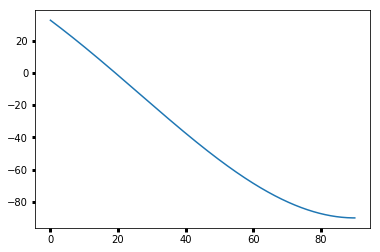

In [10]:
# 2019 Jan 18 - Working out the relationship between delta and Aplanet

# Just the thermal component

# in units of pi
delta_phi0 = np.linspace(0., np.pi/2., 1000)

# projected area-weighted average phi
avg_phi = (np.pi - np.cos(delta_phi0) - (delta_phi0 + np.pi/2.)*np.sin(delta_phi0))
delta = avg_phi - np.pi/2.

plt.plot(delta_phi0*180./np.pi, delta*180./np.pi)

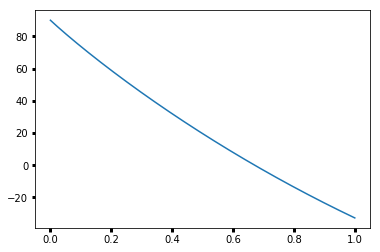

In [67]:
# 2019 Jan 18 - Working out the relationship between delta and Aplanet

# What about a thermal component on the eastern hemisphere extending from phi_0 to the eastern terminator?

# in units of pi
phi0 = np.linspace(0.5, 1., 1000)*np.pi

# projected area-weighted average phi
avg_phi = np.sin(phi0) - phi0*np.cos(phi0)
delta = avg_phi - np.pi/2.
emitted = 1. + np.cos(phi0)
emitted /= np.max(emitted)

plt.plot(emitted, delta*180./np.pi)
# plt.plot(phi0*180./np.pi, emitted)

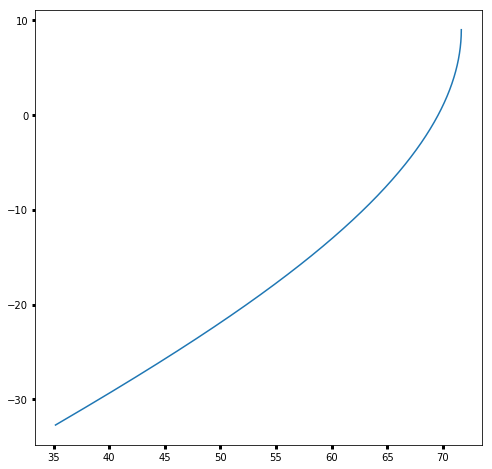

In [99]:
# 2019 Jan 18 - Working out the relationship between delta and Aplanet

# in units of pi
phi0 = np.linspace(0., 25.*np.pi/180., 1000)

avg_phi = (np.sin(phi0) - phi0*np.cos(phi0)) + (np.pi - np.cos(phi0) - (np.pi/2. + phi0)*np.sin(phi0))
delta = np.pi/2. - avg_phi
sig = (1. - np.cos(phi0)) + (1 - np.sin(phi0))

fig = plt.figure(figsize=(8,8))

# plt.plot(refl, delta*180./np.pi)
# plt.plot(phi0*180./np.pi, delta*180./np.pi)
# plt.axhline(-8.6)

plt.plot(refl, delta*180./np.pi)

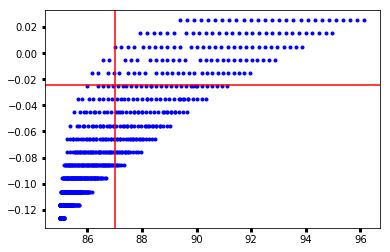

In [53]:
def calc_phase_curve(alpha, alphaemit, alpharefl, femit, frefl):
    phi_emit = 0.
    phi_refl = 0.
    
    if(alpha - np.pi/2. <= alphaemit):
        phi1_emit = np.max([0., np.pi/2. - (alpha - np.pi/2.)])
        phi2_emit = np.min([np.pi, np.pi/2. + (alphaemit - alpha)])
        
        phi_emit = femit*(np.cos(phi1_emit) - np.cos(phi2_emit))
    if(alpha + np.pi/2. >= alpharefl):
        phi1_refl = np.max([0, np.pi - ((alpha + np.pi/2.) - alpharefl)])
        phi2_refl = np.min([np.pi, 3.*np.pi/2. - (alpha + np.pi/2.) + np.pi])
    
        phi_refl = frefl*(np.cos(phi1_refl) - np.cos(phi2_refl))

    return phi_emit + phi_refl

def reverse_calc_phase_curve(alpha, alpharefl, femit, frefl):
    return -calc_phase_curve(alpha, alpharefl, femit, frefl)

def calc_phase_offset(alpharefl, femit, frefl, alphaemit=np.pi):
    return fmin(reverse_calc_phase_curve, np.pi, args=(alpharefl, femit, frefl), disp=False)    

# 2019 Jan 21 - Experimenting with phase curve
alpharefl = 3.*np.pi/2. - 0.1
alphaemit = np.pi

calc_phase_curve_vec = np.vectorize(calc_phase_curve)
reverse_calc_phase_curve_vec = np.vectorize(reverse_calc_phase_curve)

baseline = 87e-6
femit = 20e-6/calc_phase_curve(0.5*(alphaemit + np.pi/2.), alphaemit, 0., 1., 0.)

amplitude_offset = 65e-6

alpharefls = np.linspace(np.pi, 3.*np.pi/2 - np.pi/100, 100)
frefls = np.linspace(0., 20e-6, 20)
for i in range(len(frefls)):
    frefls[i] /= calc_phase_curve(0.5*(alpharefls[i] + 3.*np.pi/2.), 0., alpharefls[i], 0., 1.)

alpha = np.linspace(0., 2.*np.pi, 100)

phase_offsets = np.zeros((len(alpharefls), len(frefls)))
amplitudes = np.zeros((len(alpharefls), len(frefls)))

for i in range(len(alpharefls)):
    for j in range(len(frefls)):
        
        y = calc_phase_curve_vec(alpha, alphaemit, alpharefls[i], femit, frefls[j]) + amplitude_offset
        mx_ind = np.argmax(y)
        phase_offsets[i, j] = alpha[mx_ind]
        amplitudes[i, j] = np.max(y)
#     plt.plot(alpha/(2.*np.pi), y*1e6)
# plt.axvline(phase_offset/(2.*np.pi))
# plt.axhline(amplitude*1e6)

plt.plot(amplitudes.flatten()*1e6, (phase_offsets - np.pi).flatten()/(2.*np.pi), 'b.')
plt.axhline(-8.7/360., color='red')
plt.axvline(87, color='red')
# plt.xlim([20, 90])